# Imports

In [6]:
import os
os.chdir('..')
import json
import pandas as pd
import numpy as np
from utils.globals import *
from utils.prompt_utils import AmbigousARCDataset
from utils.plot_utils import plot_item
from utils.eval import Eval
from utils.globals import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

items = json.load(open(ITEMS_FILE, 'rb'))
results_dir = 'data/random_cleanprompt'
data = json.load(open(f'{results_dir}/multiple_choice.json', 'r'))
data_random = json.load(open(f'{results_dir}/multiple_choice_random.json', 'r'))

dataset = AmbigousARCDataset(items, 
    question_type='multiple_choice', 
    random_mat=False, 
    seed=5
)
mc = Eval(data, dataset)

dataset_random = AmbigousARCDataset(items, 
    question_type='multiple_choice', 
    random_mat=True, 
    seed=45
)
mc_random = Eval(data_random, dataset_random)

print('Two Answer Options:')
mc.print()

print('Three answer options')
mc_random.print()

Two Answer Options:


Number of models: 13
Concept: 0.76
Matrix: 0.24

Total excluded models: 26/39 (67%)
9/39 (23%) models excluded due to high no response rate.
17/39 (44%) models excluded due to biased answer choices.

Three answer options


Number of models: 11
Concept: 0.67
Matrix: 0.27
Random: 0.06

Total excluded models: 28/39 (72%)
10/39 (26%) models excluded due to high no response rate.
18/39 (46%) models excluded due to biased answer choices.

In [7]:
print(AmbigousARCDataset(items, batch_size=1, question_type='multiple_choice', random_mat=True, seed=42).x[0])

EXAMPLE TASK:

Input 1: [3 0 3] [3 0 3] [7 0 3]
Output 1: [3 0 3] [3 0 3] [7 0 7]
Input 2: [3 0 3] [7 0 3] [3 0 3]
Output 2:

(a) [3 3 3] [7 0 3] [3 0 3]
(b) [3 0 3] [7 0 7] [3 0 3]
(c) [3 0 3] [7 0 3] [3 0 7]

Answer: (b)

TEST TASK:

Input 1: [0 3 0] [2 3 2] [0 3 0]
Output 1: [0 3 0] [2 2 2] [0 3 0]
Input 2: [3 0 0] [3 1 1] [3 0 0]
Output 2:

(a) [3 0 0] [1 1 1] [3 0 0]
(b) [2 3 3] [0 3 3] [0 3 0]
(c) [3 0 0] [3 2 1] [3 0 0]

Answer: (


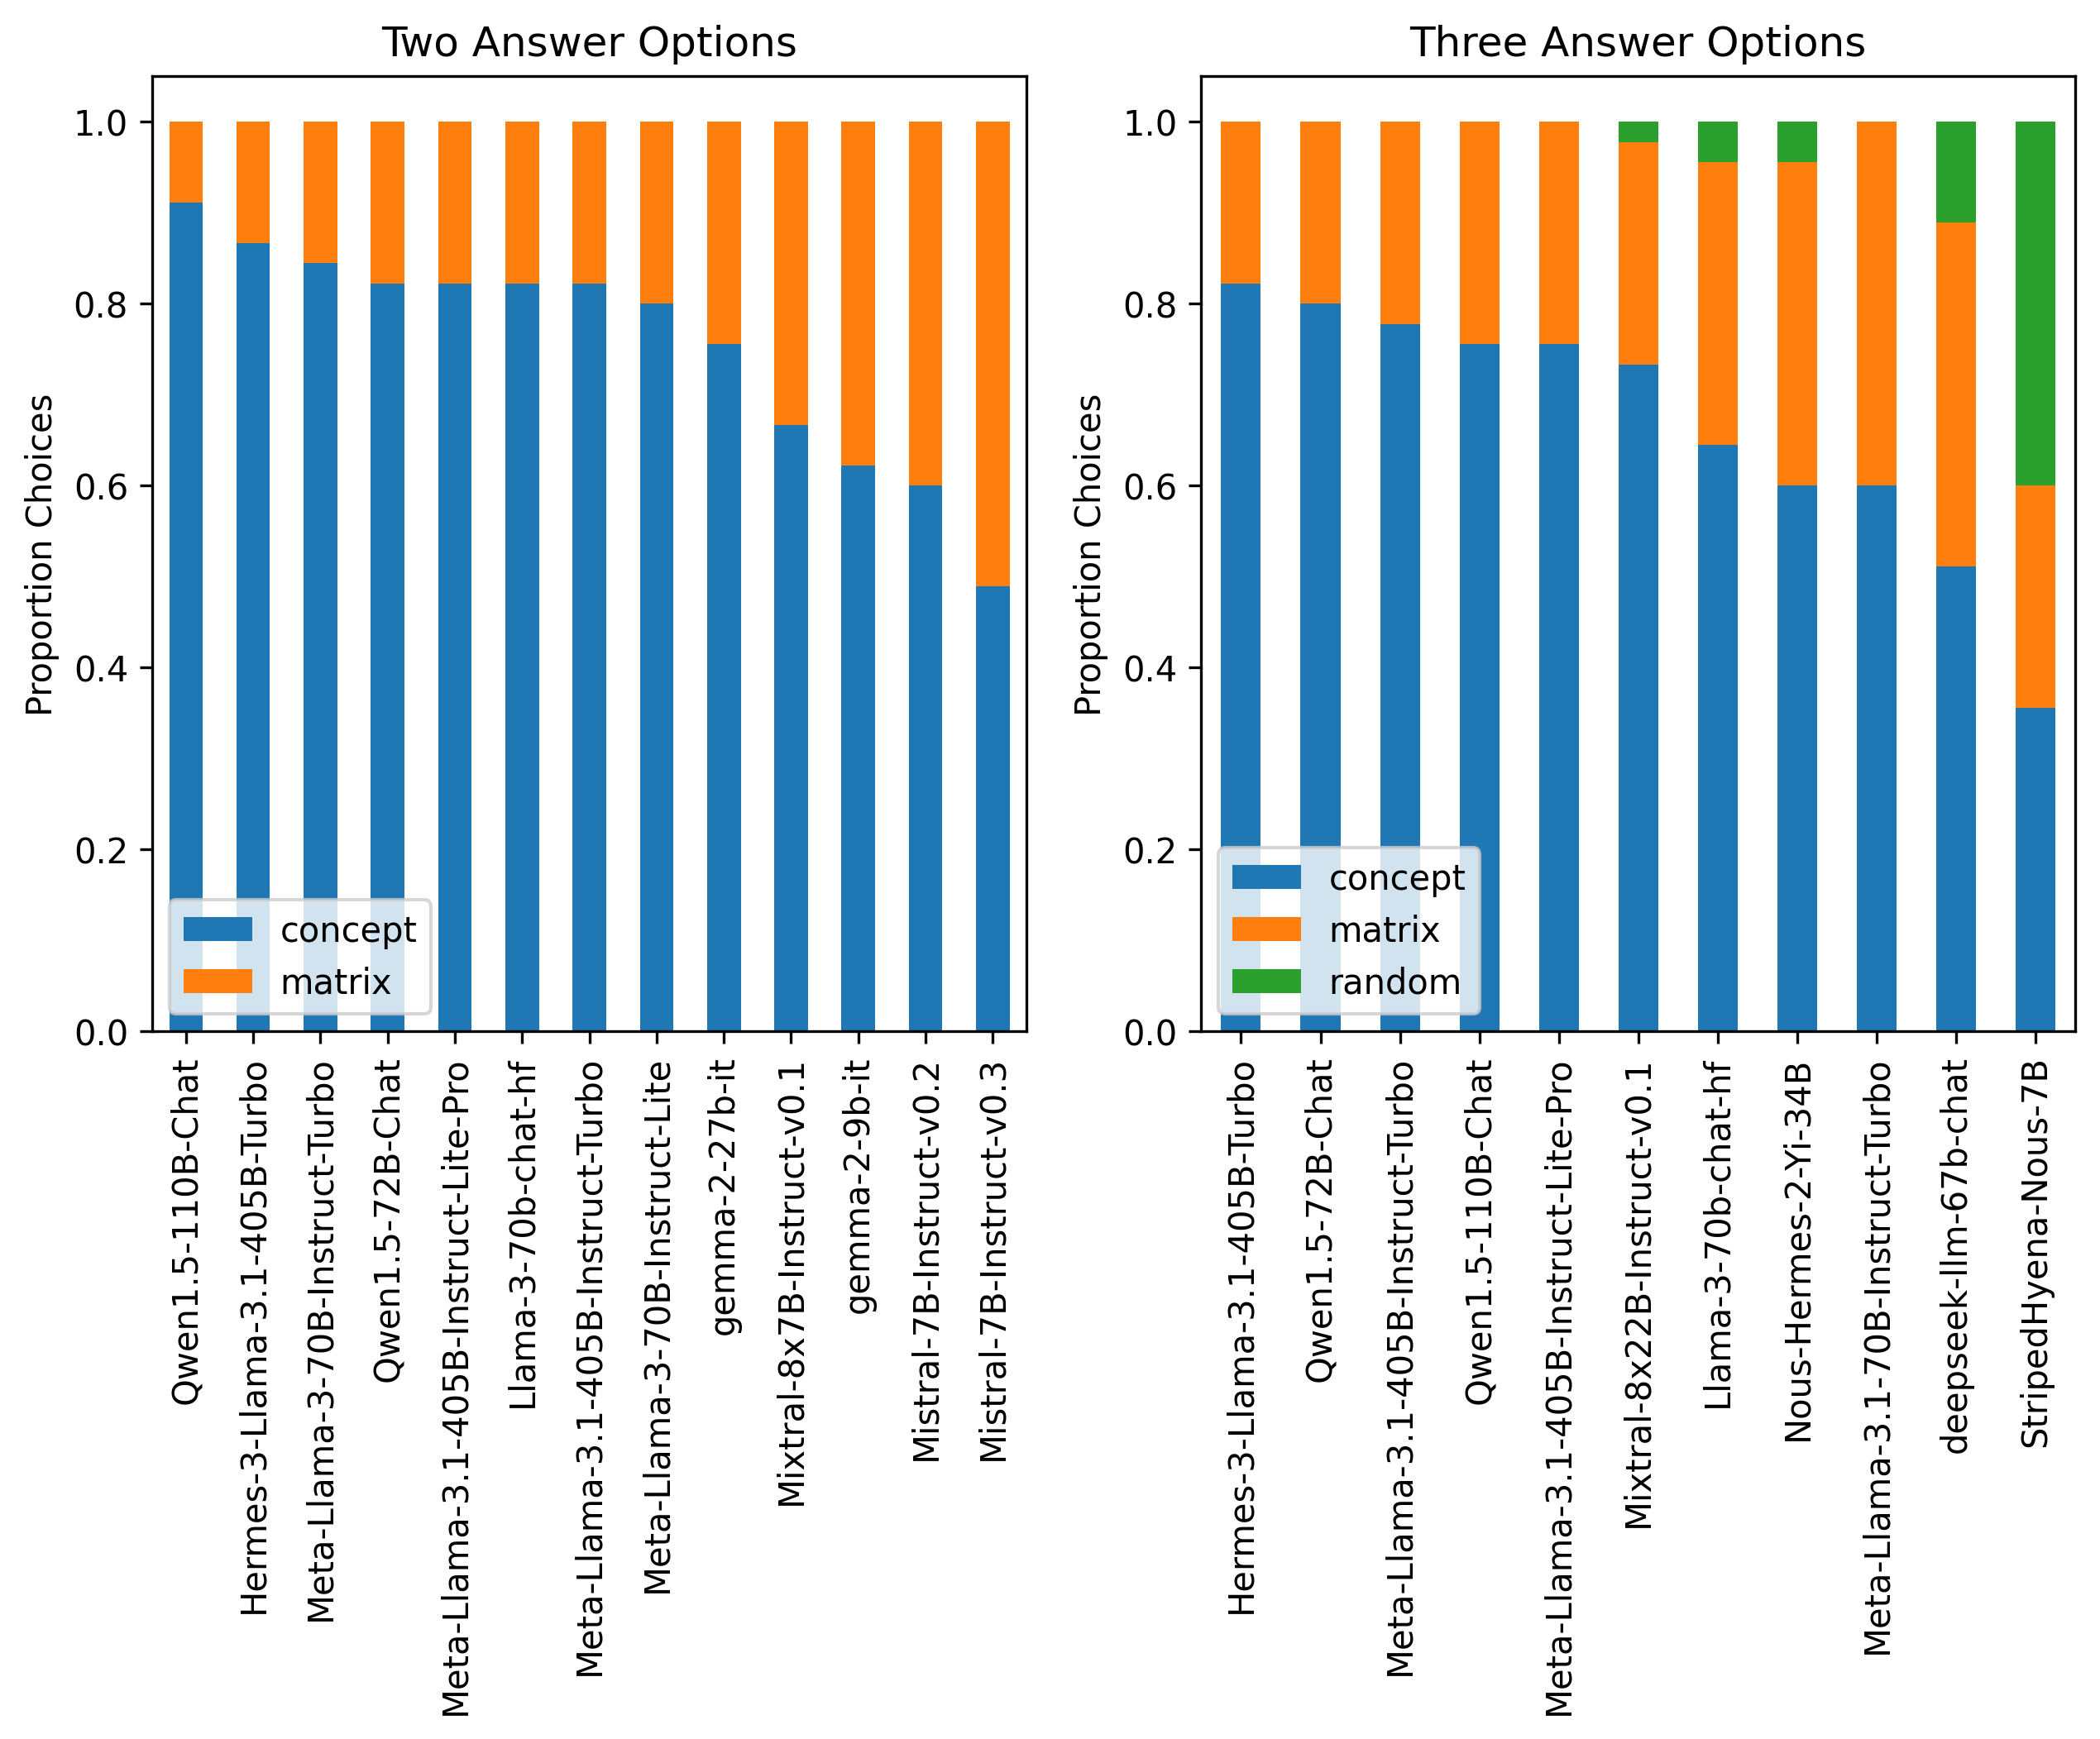

In [8]:
df_stacked_random = pd.DataFrame({
    'concept': mc_random.concept_responses,
    'matrix': mc_random.matrix_responses,
    'random': mc_random.random_responses
})
df_stacked_random.index = [model.split('/')[1] for model in mc_random.models_names]
df_stacked_random = df_stacked_random.sort_values(by='concept', ascending=False)

df_stacked = pd.DataFrame({
    'concept': mc.concept_responses,
    'matrix': mc.matrix_responses,
})
df_stacked.index = [model.split('/')[1] for model in mc.models_names]
df_stacked = df_stacked.sort_values(by='concept', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Two Answer Options')
df_stacked.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_ylabel('Proportion Choices')
ax[0].legend(loc='lower left')
ax[0].set_xticks(np.arange(0, len(df_stacked), 1))
ax[0].set_xticklabels(df_stacked.index, rotation=90)

ax[1].set_title('Three Answer Options')
df_stacked_random.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_ylabel('Proportion Choices')
ax[1].legend(loc='lower left')
ax[1].set_xticks(np.arange(0, len(df_stacked_random), 1))
ax[1].set_xticklabels(df_stacked_random.index, rotation=90)
plt.show()


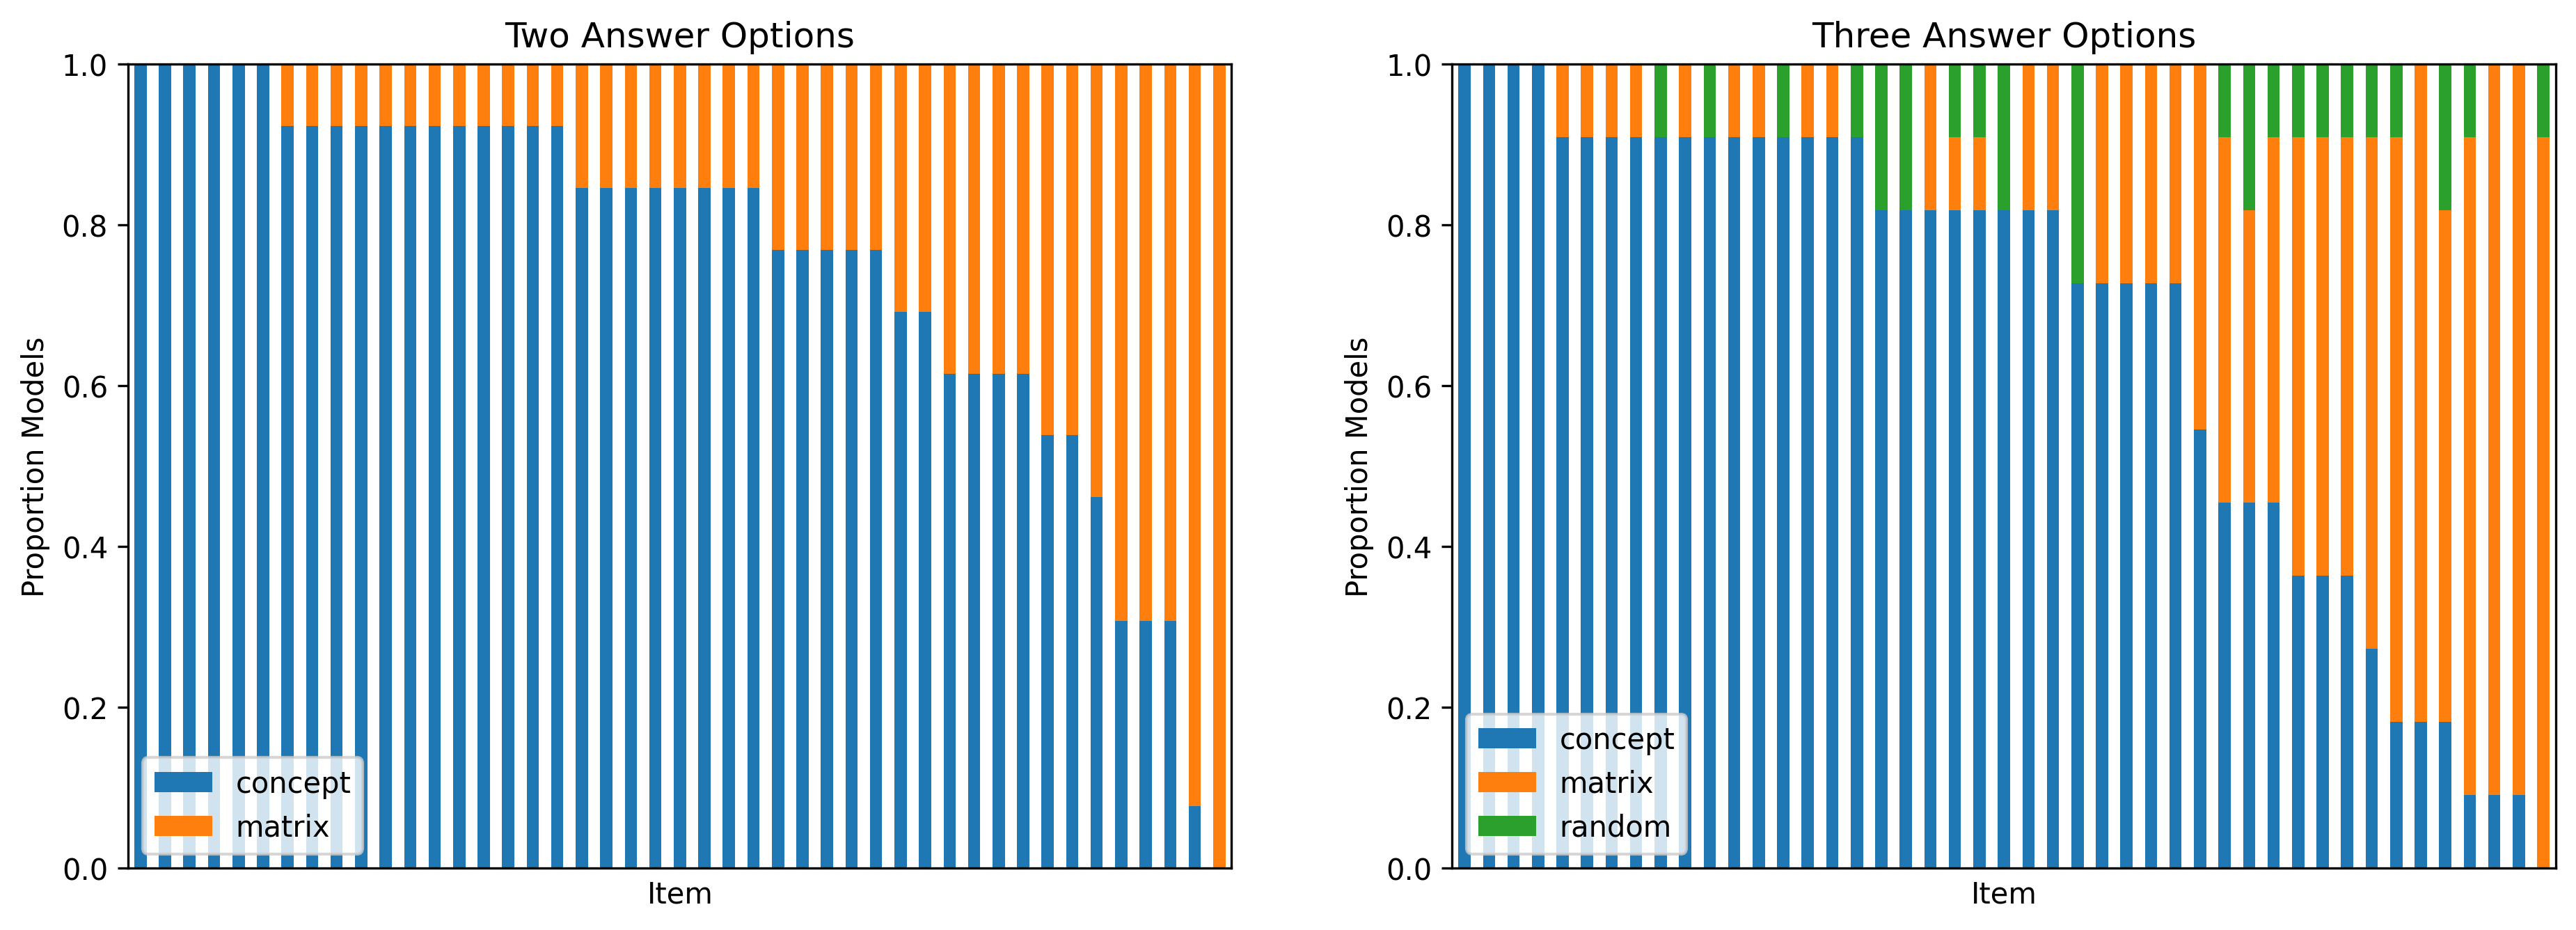

In [9]:
df_stacked_items = pd.DataFrame({
    'concept': mc.df.groupby('item_id')['concept_response'].mean(),
    'matrix': mc.df.groupby('item_id')['matrix_response'].mean(),
})
df_stacked_items = df_stacked_items.sort_values(by='concept', ascending=False)

df_stacked_items_random = pd.DataFrame({
    'concept': mc_random.df.groupby('item_id')['concept_response'].mean(),
    'matrix': mc_random.df.groupby('item_id')['matrix_response'].mean(),
    'random': mc_random.df.groupby('item_id')['random_response'].mean()
})
df_stacked_items_random = df_stacked_items_random.sort_values(by='concept', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Two Answer Options')
df_stacked_items.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_ylabel('Proportion Models')
ax[0].legend(loc='lower left')
ax[0].set_xticks([])
ax[0].set_xlabel('Item')
ax[0].set_ylim(0, 1)

ax[1].set_title('Three Answer Options')
df_stacked_items_random.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_ylabel('Proportion Models')
ax[1].legend(loc='lower left')
ax[1].set_xticks([])
ax[1].set_xlabel('Item')
ax[1].set_ylim(0, 1)

plt.show()

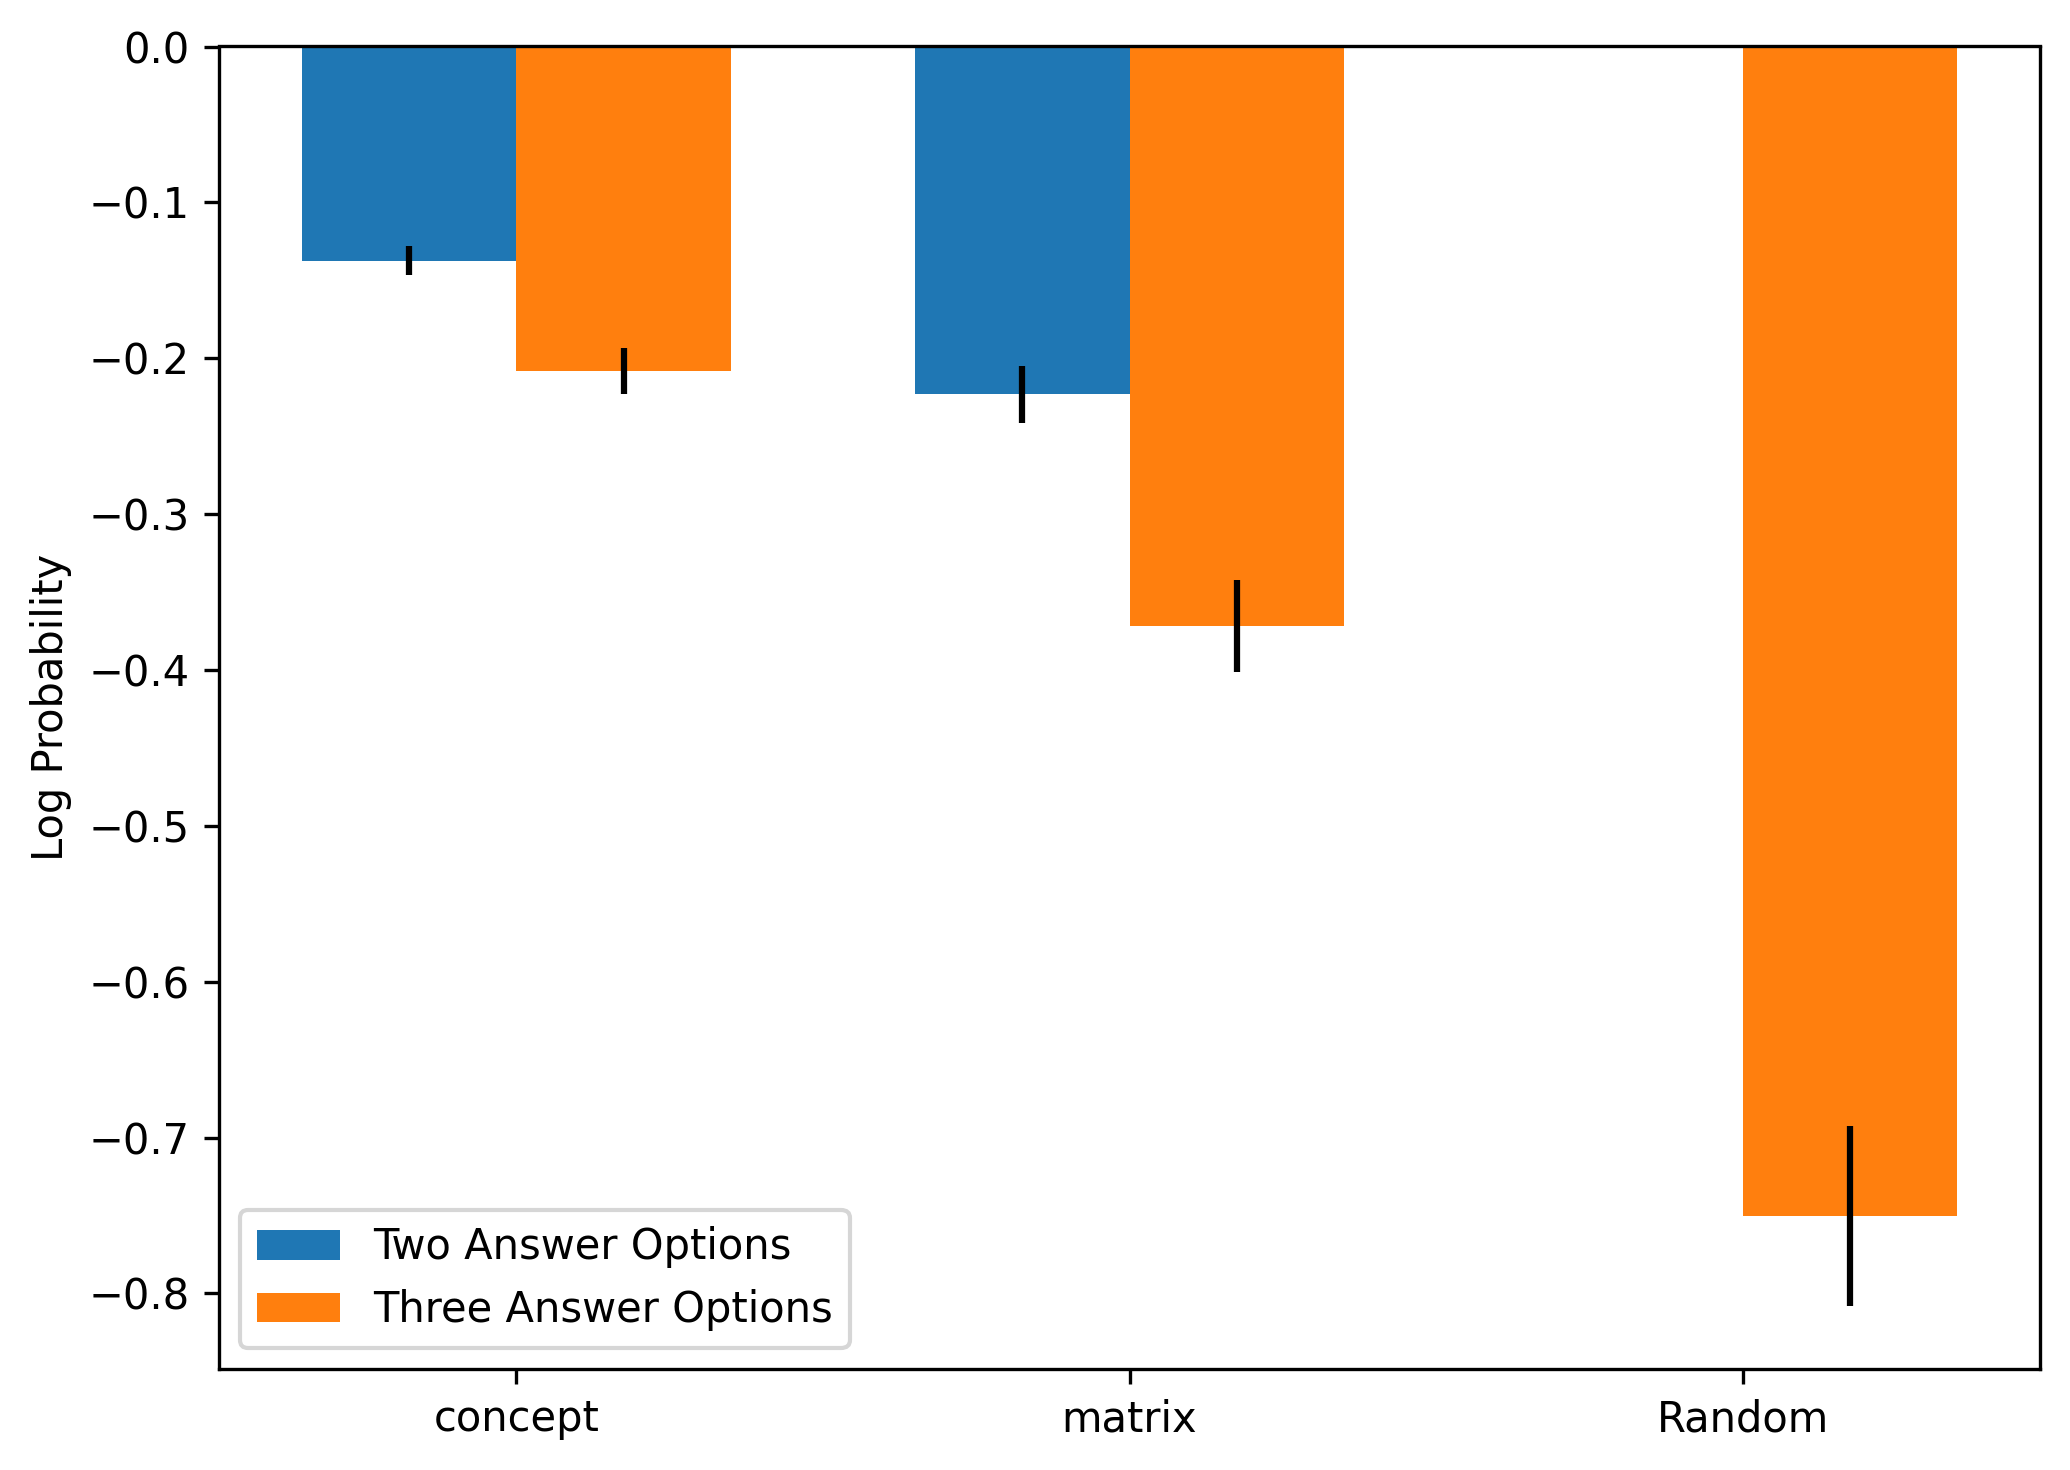

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate means and errors
means_mc = mc.df.groupby('choice')['logprobs'].mean()
errors_mc = mc.df.groupby('choice')['logprobs'].sem()

means_mc_random = mc_random.df.groupby('choice')['logprobs'].mean()
errors_mc_random = mc_random.df.groupby('choice')['logprobs'].sem()

# Adjust shapes by padding the smaller dataset with NaN
if len(means_mc) < len(means_mc_random):
    means_mc = pd.concat([means_mc, pd.Series([np.nan], index=['Random'])])
    errors_mc = pd.concat([errors_mc, pd.Series([np.nan], index=['Random'])])
elif len(means_mc_random) < len(means_mc):
    means_mc_random = pd.concat([means_mc_random, pd.Series([np.nan], index=['Random'])])
    errors_mc_random = pd.concat([errors_mc_random, pd.Series([np.nan], index=['Random'])])

# Define width for bars and positions
bar_width = 0.35
index = np.arange(len(means_mc))  # Assuming both are now the same length

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the bars
bars_mc = ax.bar(index, means_mc, bar_width, yerr=errors_mc, label='Two Answer Options')
bars_mc_random = ax.bar(index + bar_width, means_mc_random, bar_width, yerr=errors_mc_random, label='Three Answer Options')

# Set labels and title
ax.set_ylabel('Log Probability')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(means_mc.index, rotation=0)

# Set limits

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [165]:
def plot_most_common(n_choices, choice, top=3):
    df = df_stacked_items_random if n_choices == 3 else df_stacked_items
    df = df.sort_values(by=choice, ascending=False)[:top]
    for i in range(top):      
        mc_random.dataset.plot(df.index[i], f'Item: {df.index[i]} {choice}: {df.iloc[i][choice] * 100:.2f}%')

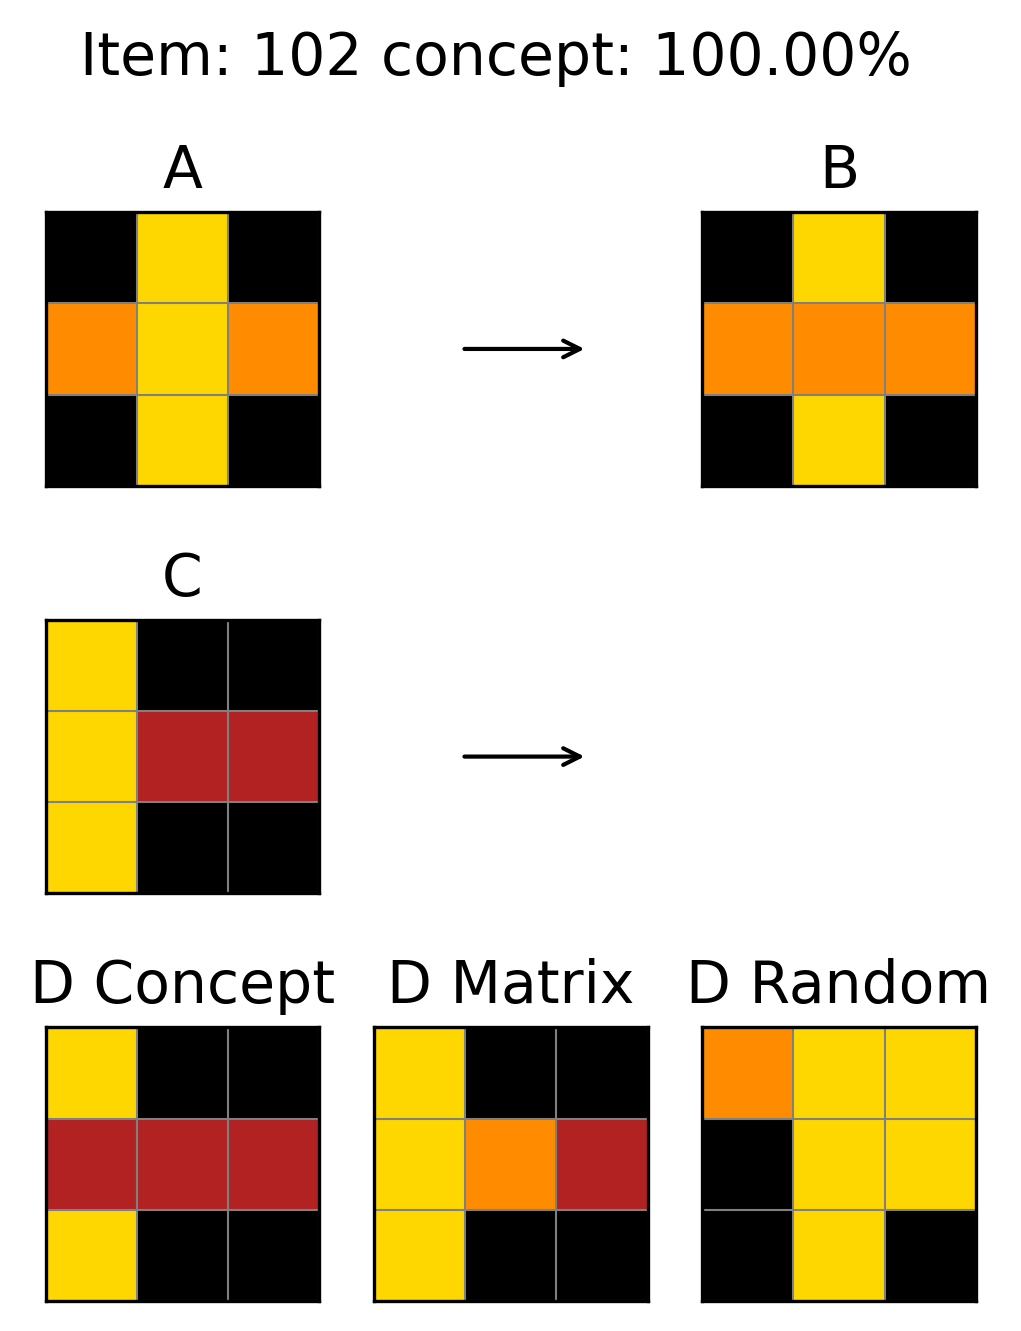

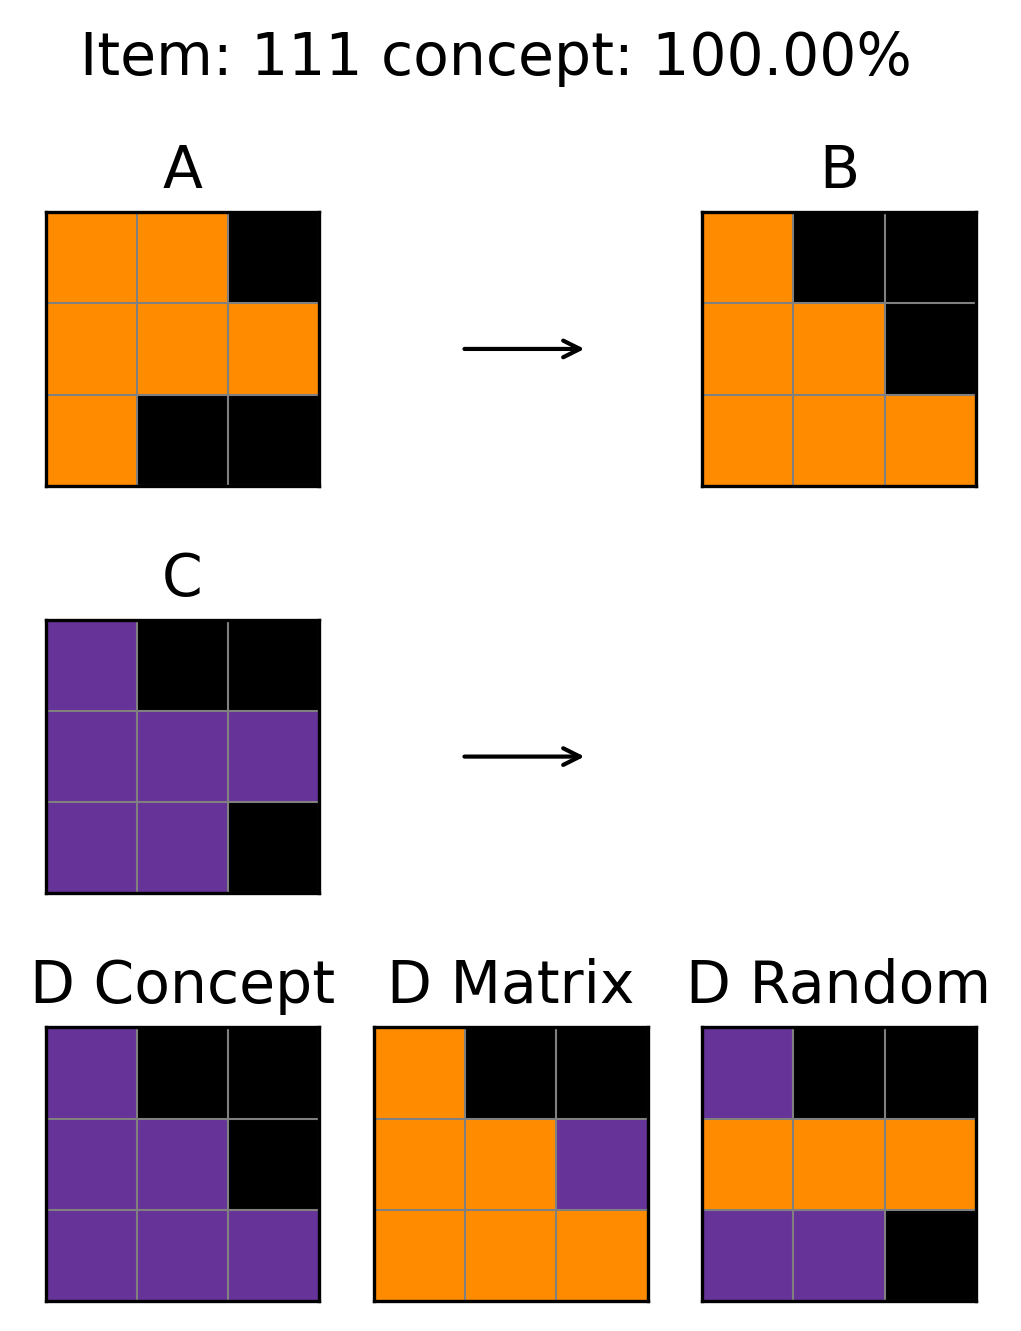

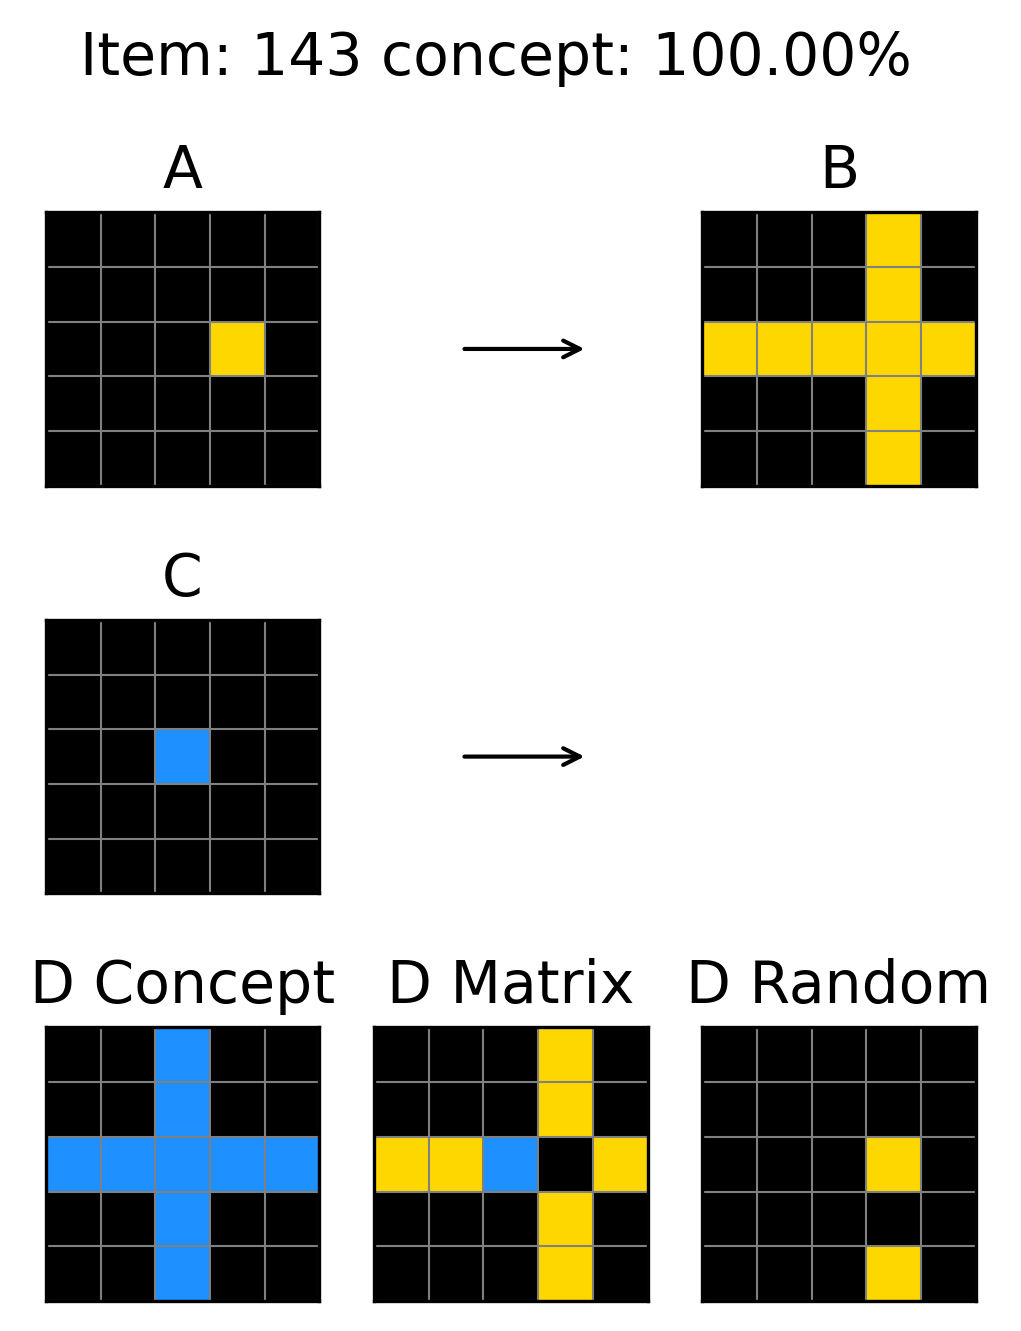

In [167]:
plot_most_common(3, 'concept', top=3)

# Concept recognition

In [13]:
results_dir = 'data/results'
data_abcd = json.load(open(f'{results_dir}/concept_task_abcd.json', 'r'))
dataset_abcd = AmbigousARCDataset(items, 
    question_type='concept_task', 
    concept_answer_n=4,
    seed=12
)
abcd = Eval(data_abcd, dataset=dataset_abcd, prop_test_thresh=None, no_response_thresh=False)

data_all = json.load(open(f'{results_dir}/concept_task_all.json', 'r'))
dataset_all = AmbigousARCDataset(items, 
    question_type='concept_task', 
    concept_answer_n=None,
    seed=9123
)
abcd_all = Eval(data_all, dataset=dataset_all, prop_test_thresh=None, no_response_thresh=False)

print('Four Answer Options:')
abcd.print()

print('All Answer Options')
abcd_all.print()


Four Answer Options:


Number of models: 41
Accuracy: 0.23

All Answer Options


Number of models: 41
Accuracy: 0.08

In [14]:
print(dataset_abcd.x[0])

EXAMPLE TASK:

Input 1: [3 0 3] [3 0 3] [7 0 3]
Output 1: [3 0 3] [3 0 3] [7 0 7]
Input 2: [3 0 3] [7 0 3] [3 0 3]
Output 2: [3 0 3] [7 0 7] [3 0 3]

Concept:
(a) Other
(b) Filled and not filled
(c) Order
(d) Copy

Answer: (d)

TEST TASK:

Input 1: [0 3 0] [2 3 2] [0 3 0]
Output 1: [0 3 0] [2 2 2] [0 3 0]
Input 2: [3 0 0] [3 1 1] [3 0 0]
Output 2: [3 0 0] [1 1 1] [3 0 0]

Concept:
(a) Copy
(b) Top and bottom 3d
(c) Other
(d) Clean up

Answer: (


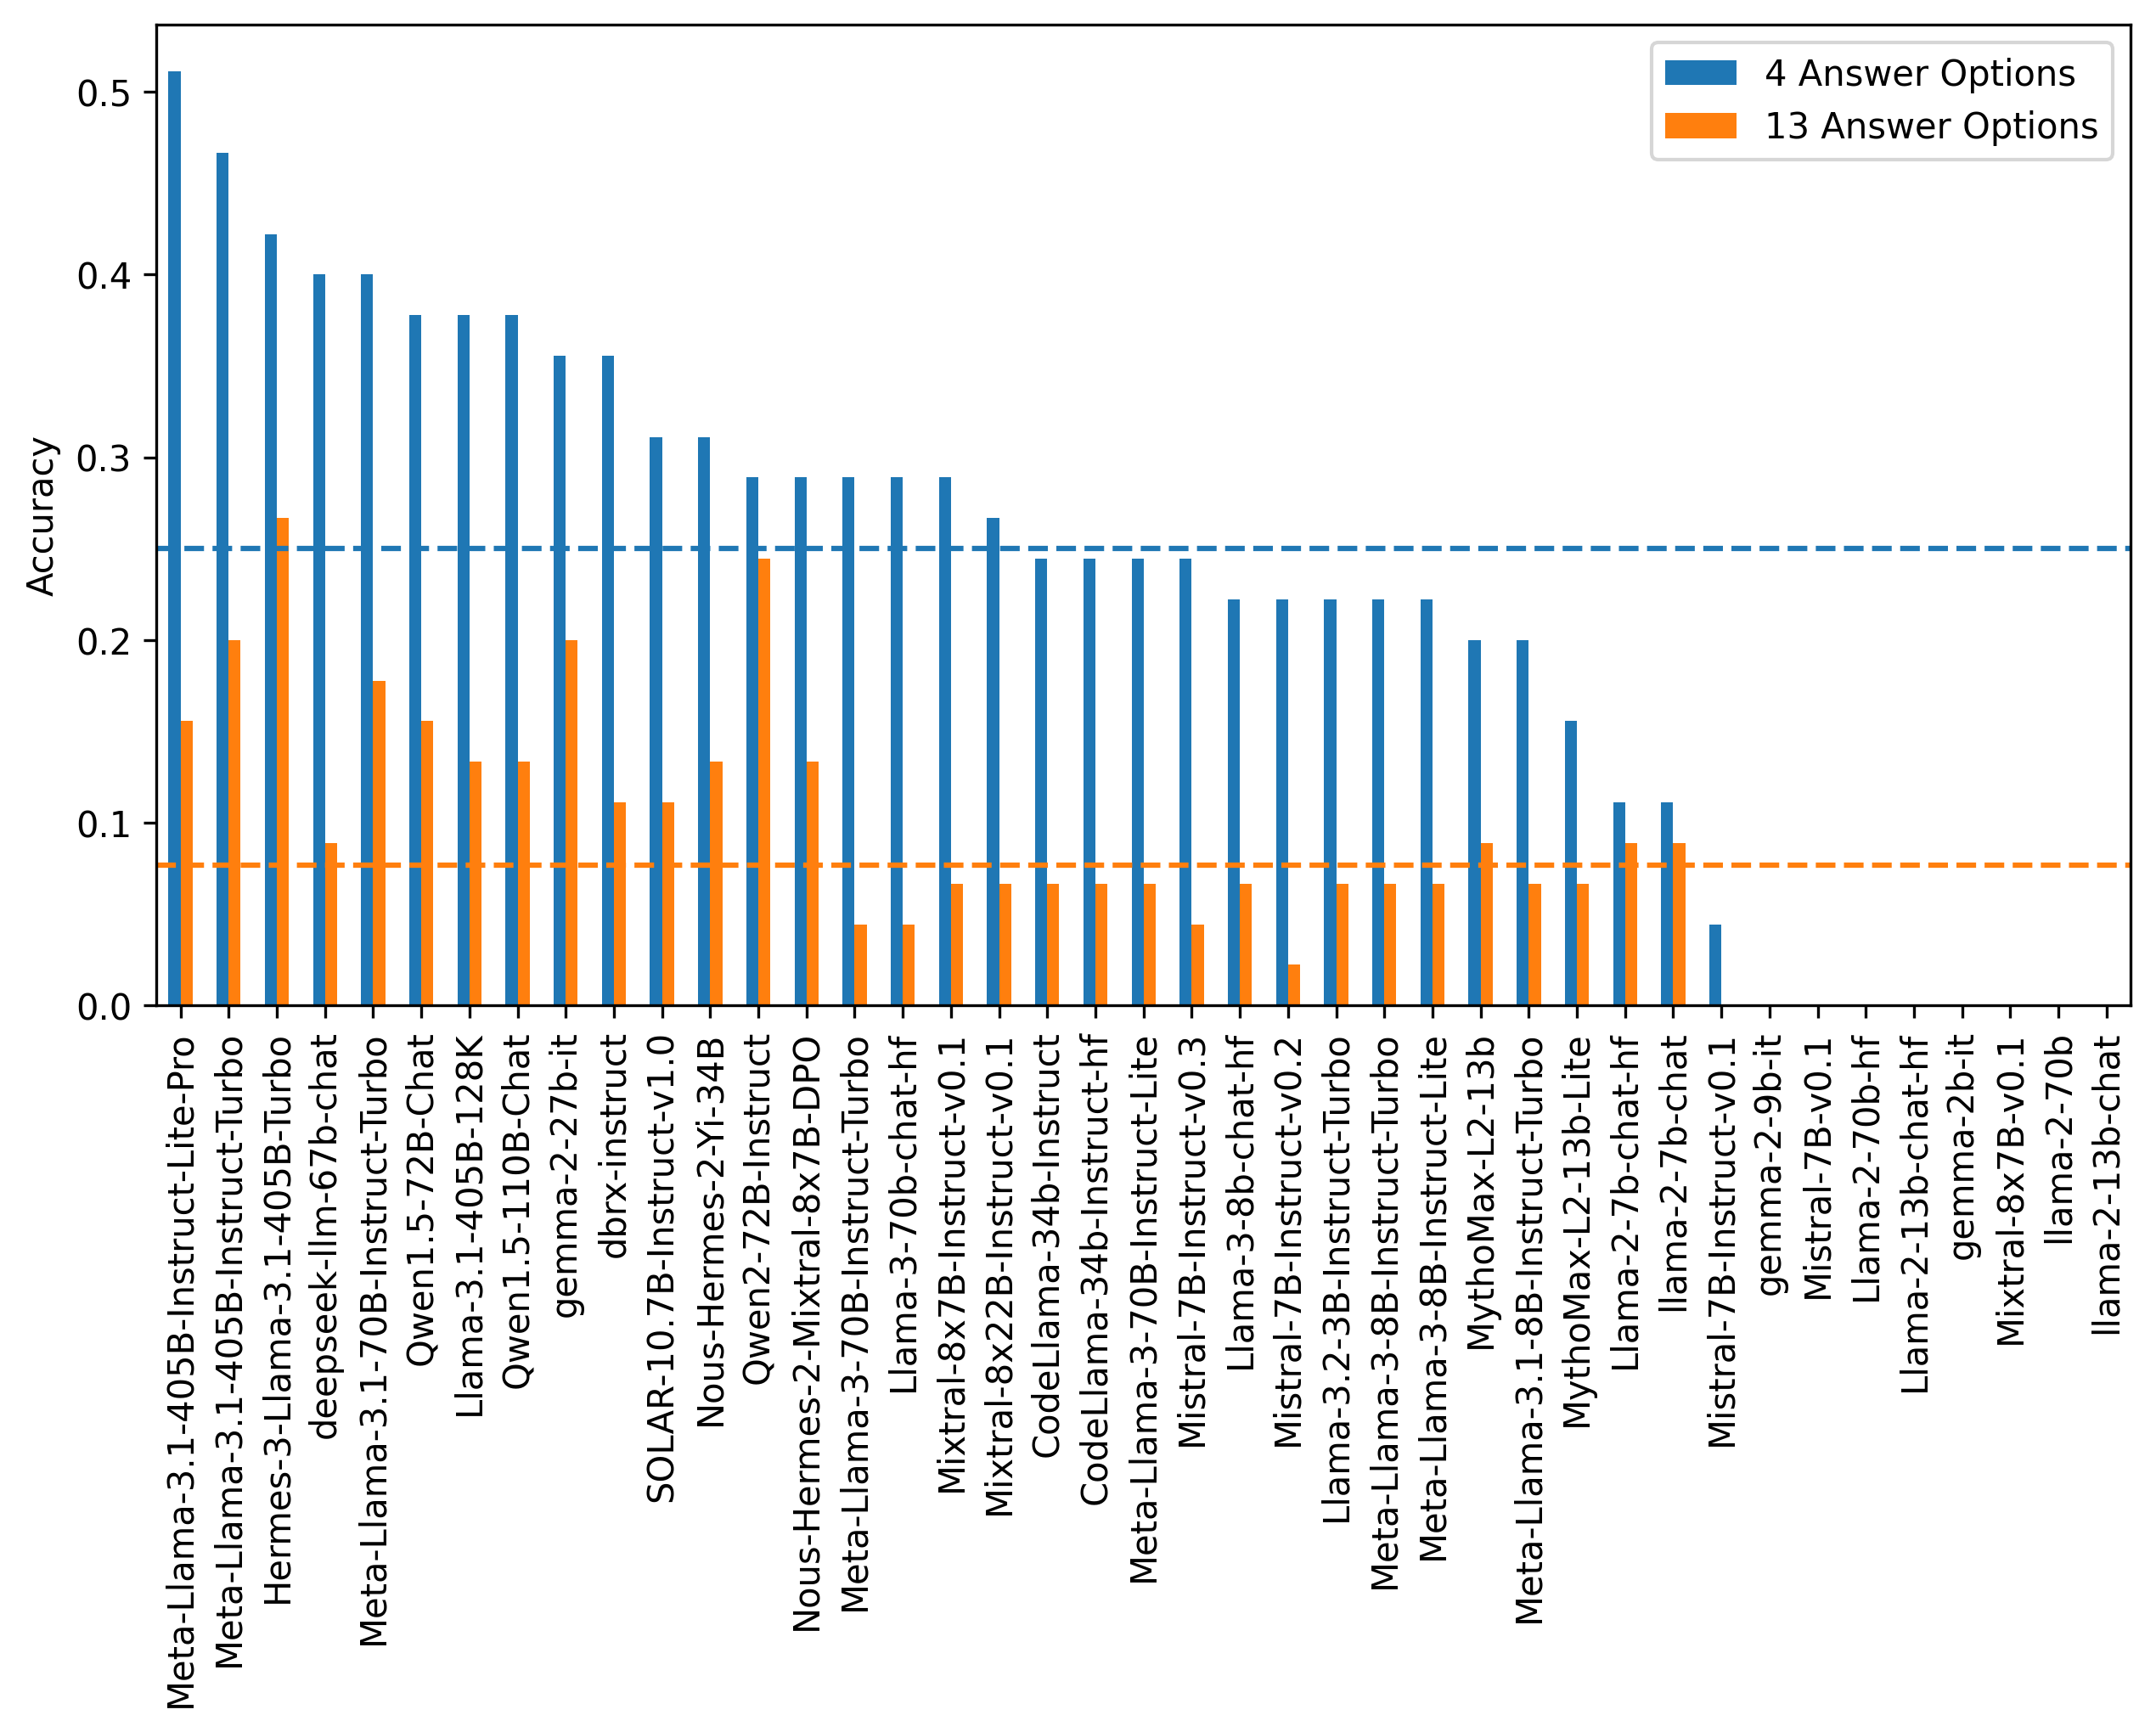

In [15]:
#bar chart with two groups
df = pd.DataFrame({
    '4 Answer Options': abcd.accuracy,
    '13 Answer Options': abcd_all.accuracy
})
df.index = abcd.models_names
df = df.sort_values(by='4 Answer Options', ascending=False)
model_names = [model.split('/')[1] for model in df.index]
df.plot(kind='bar', figsize=(10, 5))
plt.ylabel('Accuracy')
plt.axhline(y=1/4, color='tab:blue', linestyle='--')
plt.axhline(y=1/13, color='tab:orange', linestyle='--')
plt.xticks(np.arange(0, len(df), 1), model_names, rotation=90)
plt.show()

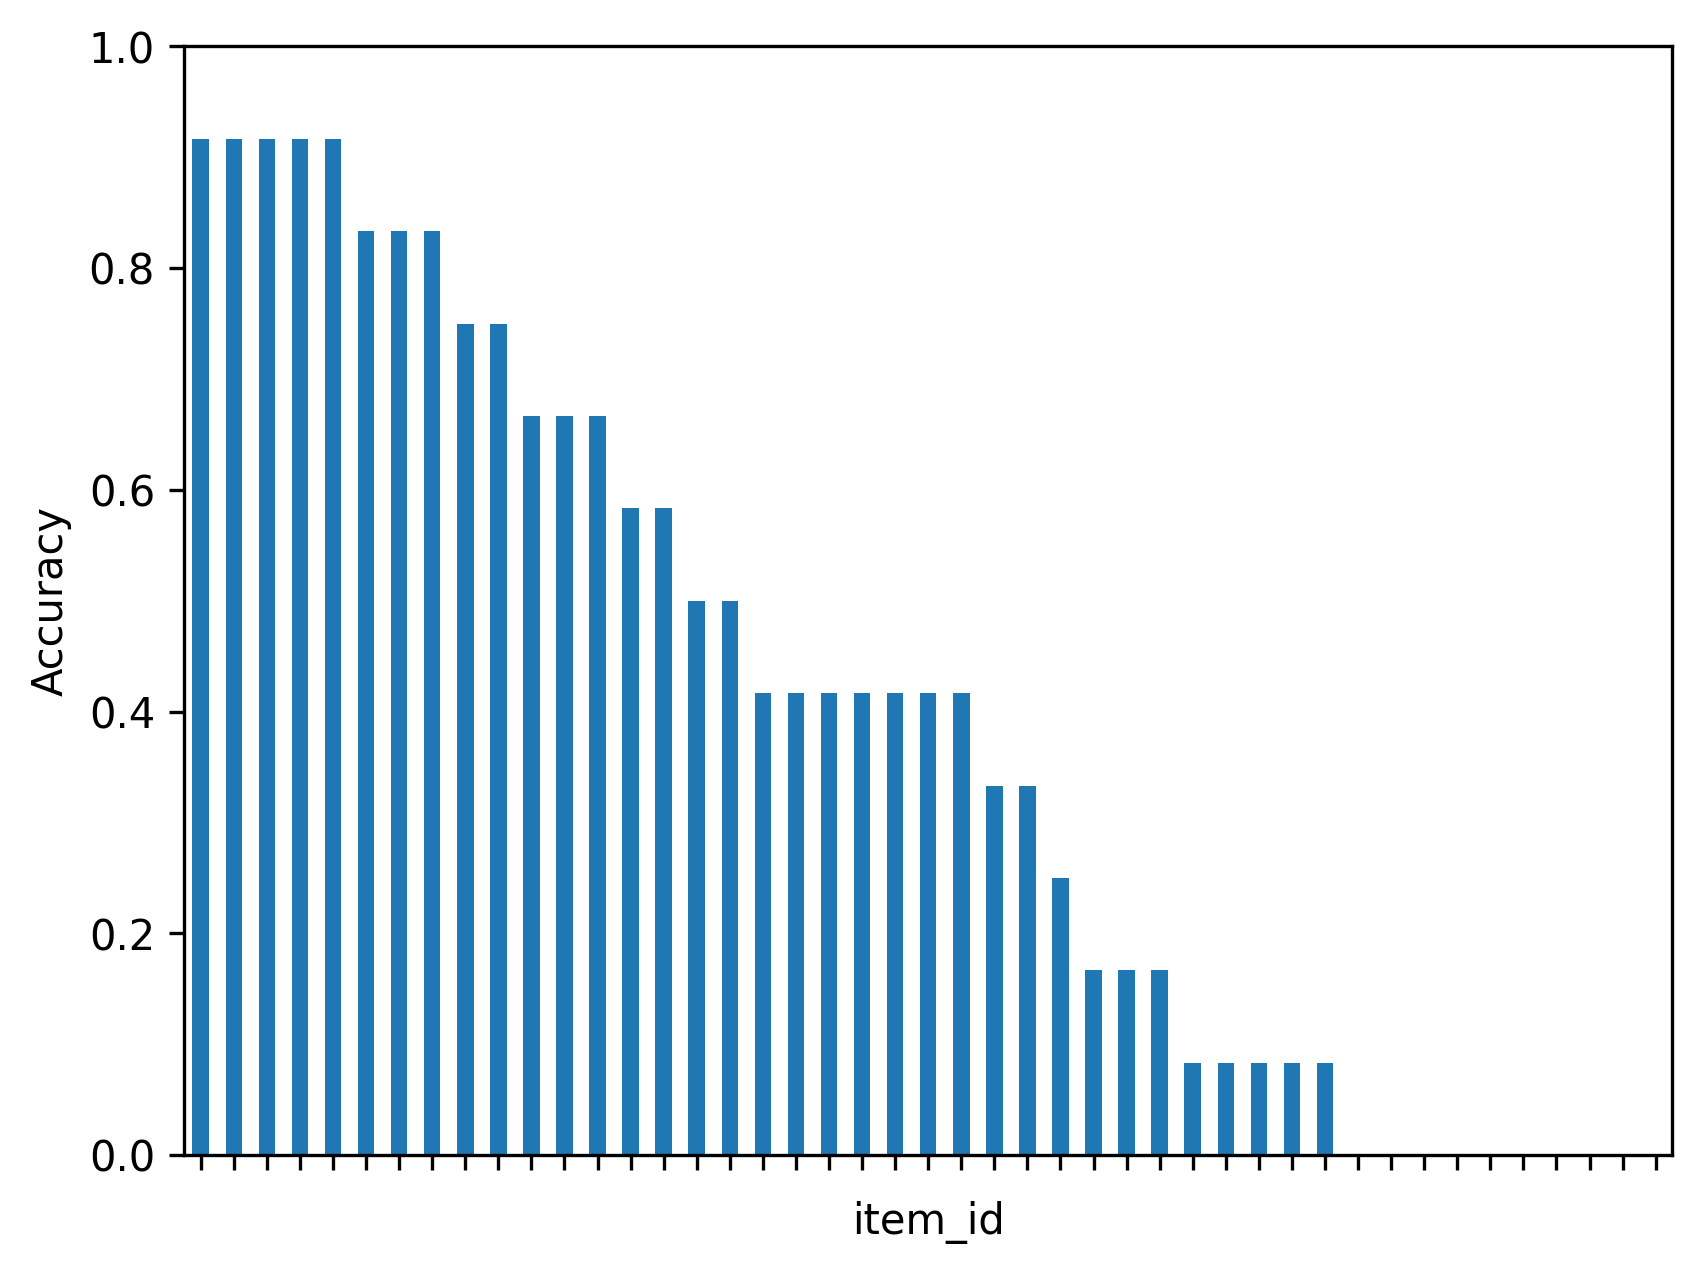

In [16]:
filtered_df = abcd.df[abcd.df['model'].isin(list(df[df['4 Answer Options'] > 0.3].index))]
filtered_df.groupby('item_id')['concept_acc'].mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Accuracy')
plt.xticks(ticks=plt.gca().get_xticks(), labels=[])
plt.ylim(0, 1)
plt.show()

In [17]:
mc_item = mc_random.df.groupby('item_id')['concept_response'].mean()
concept_recognition = filtered_df.groupby('item_id')['concept_acc'].mean()
# correlation between concept recognition and concept response
np.corrcoef(mc_item, concept_recognition)



array([[1.        , 0.19744338],
       [0.19744338, 1.        ]])

In [18]:
filtered_df.groupby('item_id')['concept_acc'].mean()

item_id
102    0.333333
103    0.916667
104    0.083333
105    0.916667
106    0.000000
107    0.916667
108    0.833333
109    0.083333
110    0.416667
111    0.583333
112    0.416667
113    0.083333
114    0.000000
115    0.666667
116    0.000000
117    0.833333
118    0.250000
119    0.166667
120    0.000000
121    0.916667
122    0.416667
123    0.333333
124    0.750000
125    0.083333
126    0.166667
127    0.000000
128    0.083333
129    0.500000
130    0.166667
131    0.416667
132    0.000000
133    0.000000
134    0.416667
135    0.583333
136    0.666667
137    0.416667
138    0.000000
139    0.916667
140    0.000000
141    0.500000
142    0.750000
143    0.666667
144    0.416667
145    0.833333
146    0.000000
Name: concept_acc, dtype: float64

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


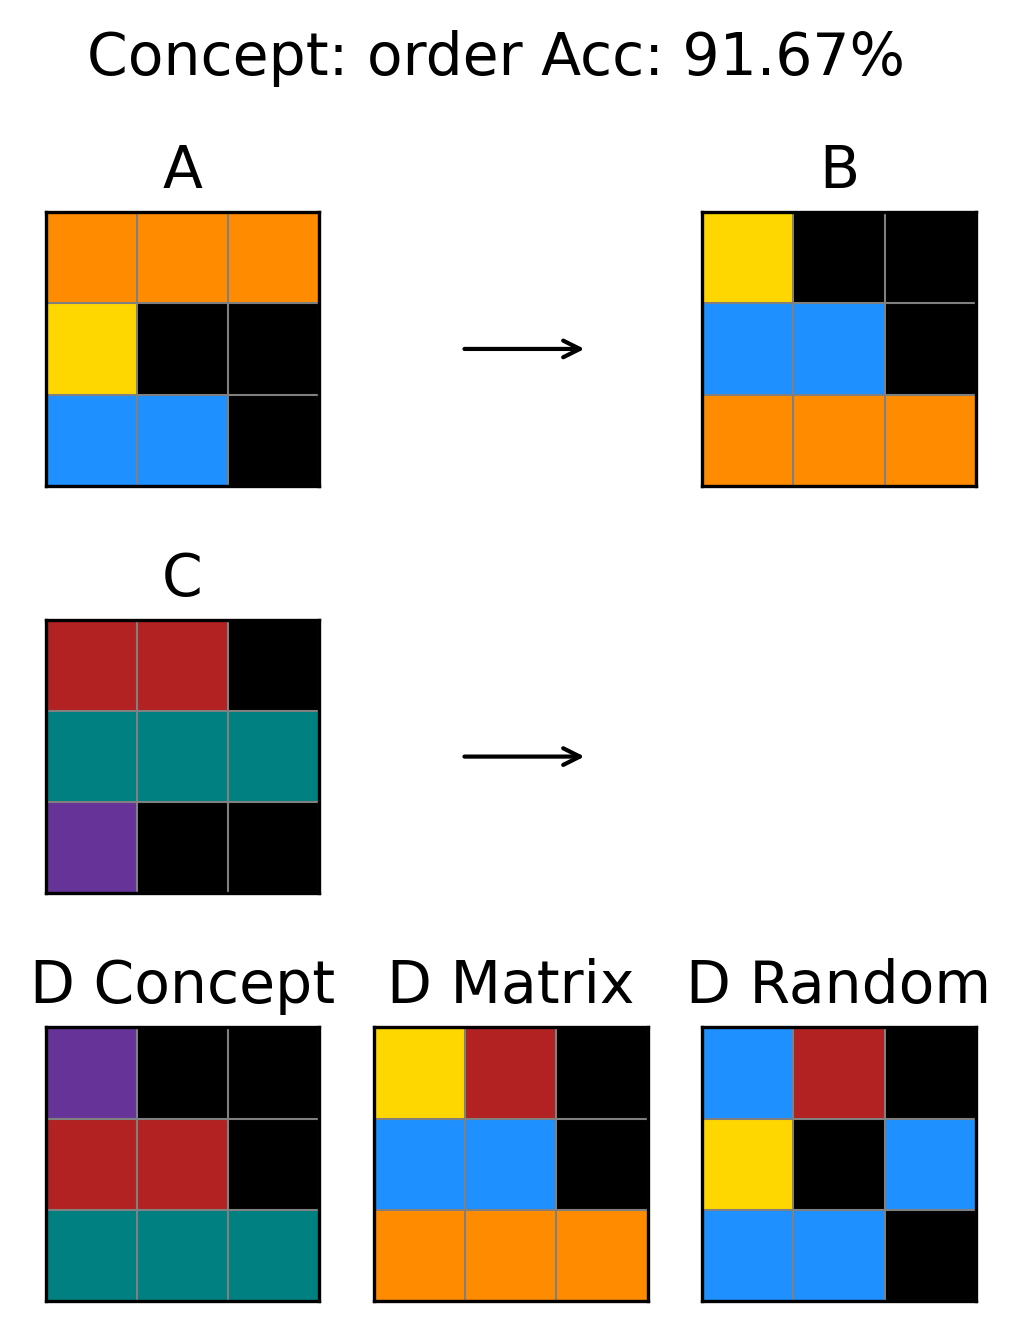

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


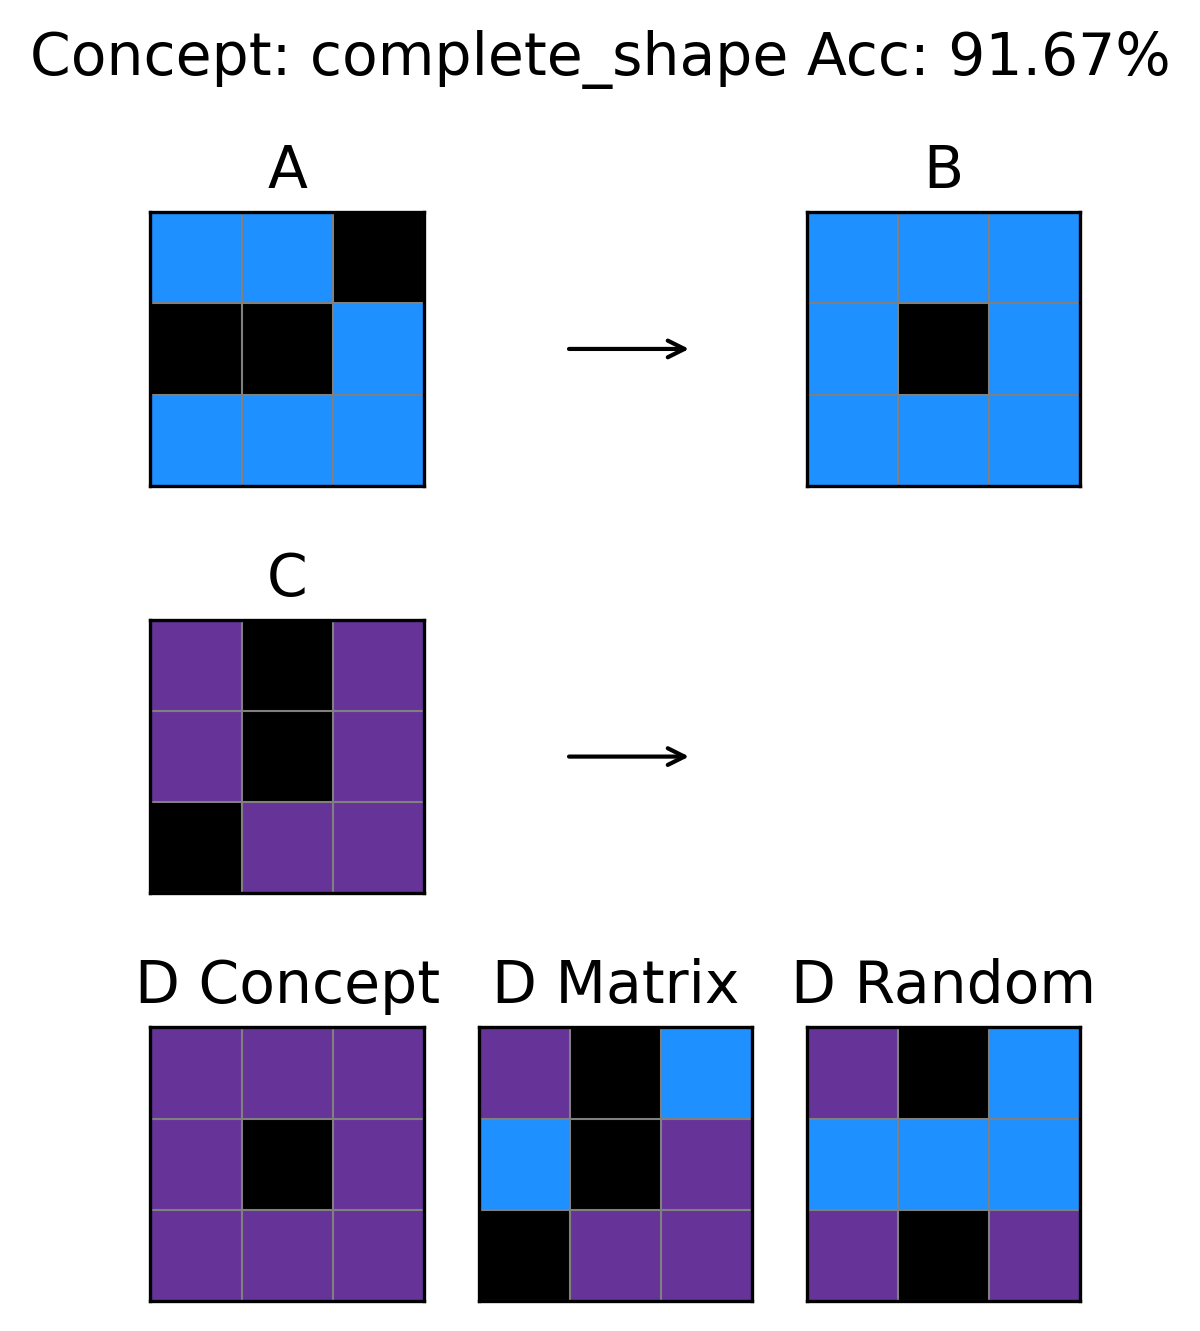

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


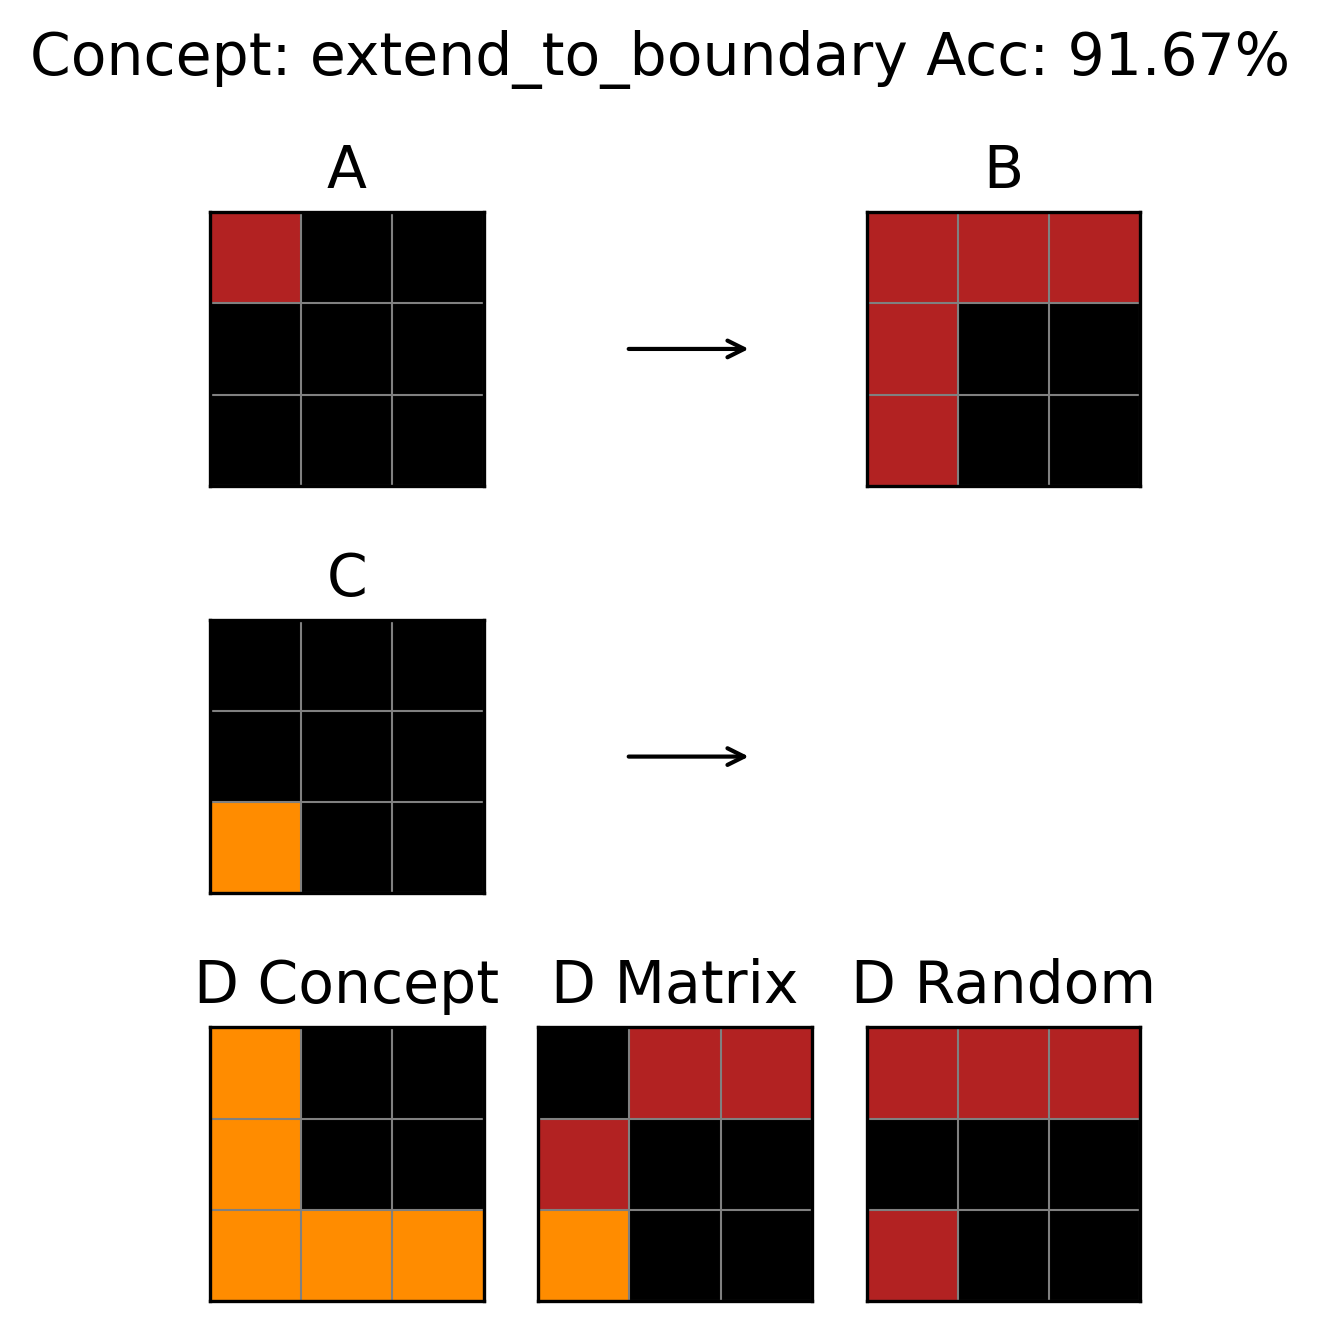

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


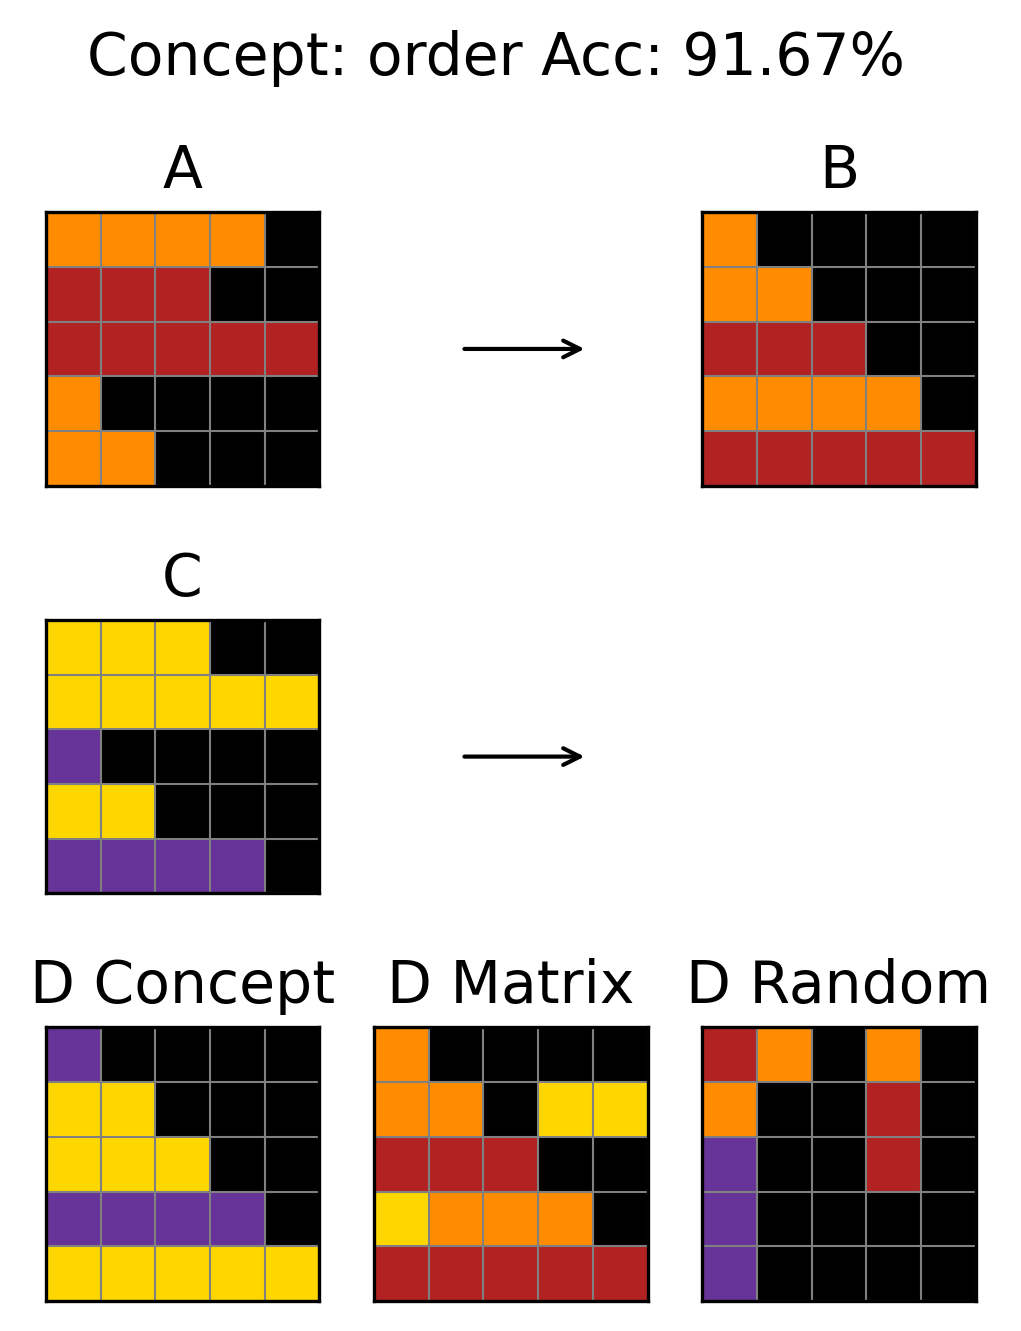

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


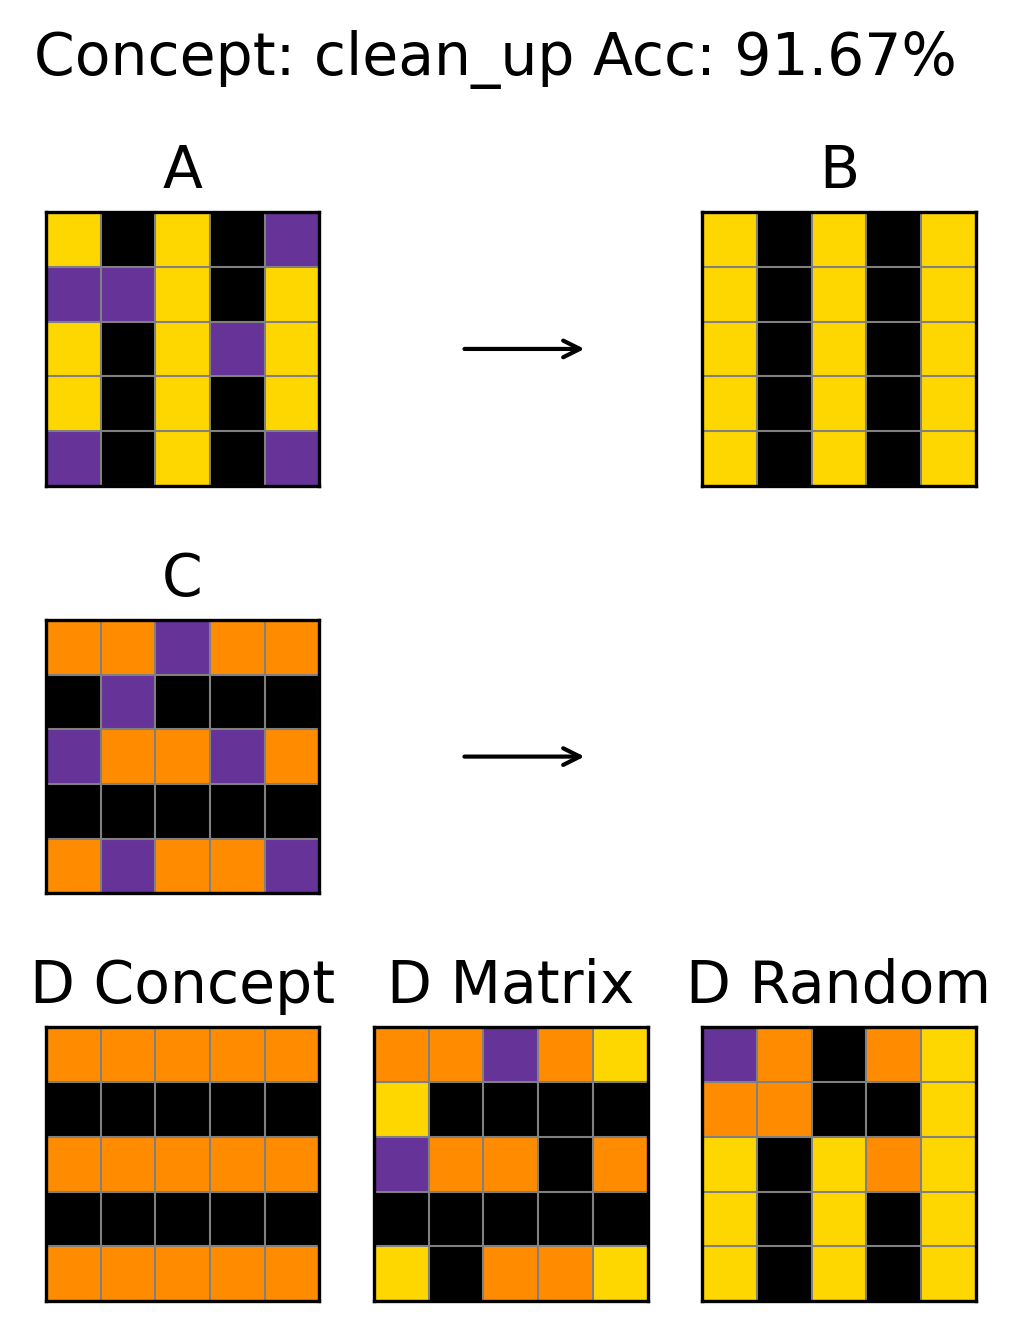

In [19]:
def plot_most_common(df, top=3, ascending=False):
    df = df.sort_values(ascending=ascending)[:top]
    for i in range(top):      
        concept = abcd.dataset.items_data[df.index[i]]['concept']
        abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')

plot_most_common(filtered_df.groupby('item_id')['concept_acc'].mean(), top=5, ascending=False)

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


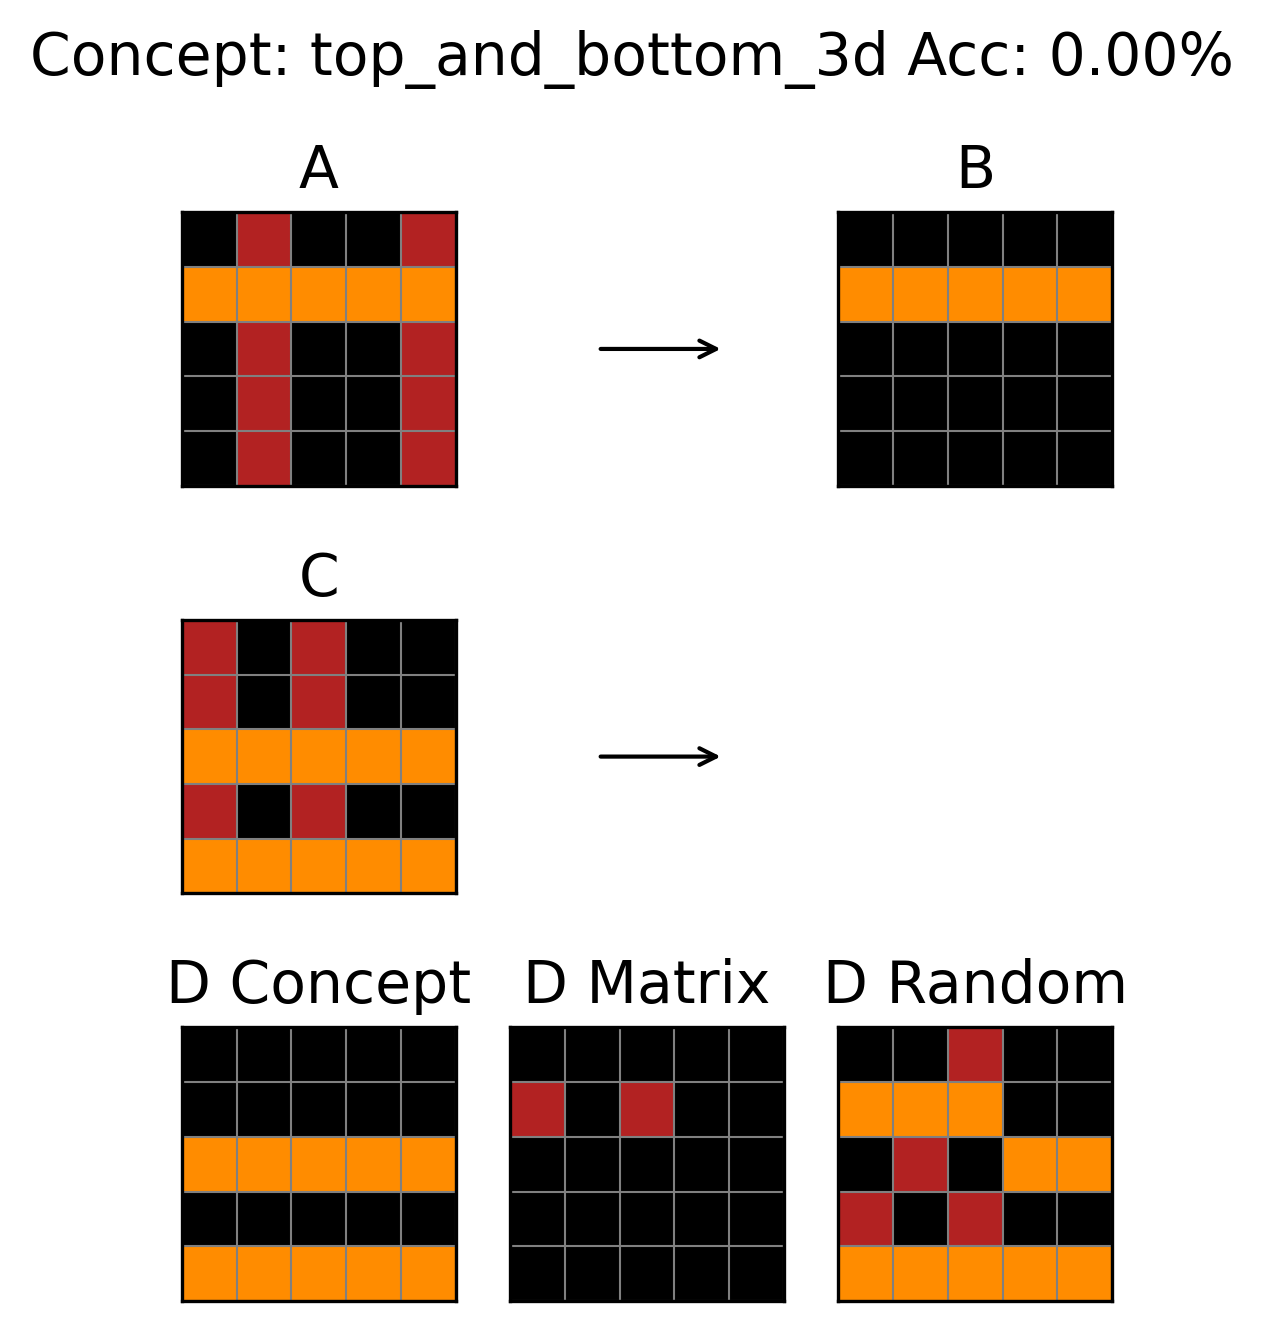

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


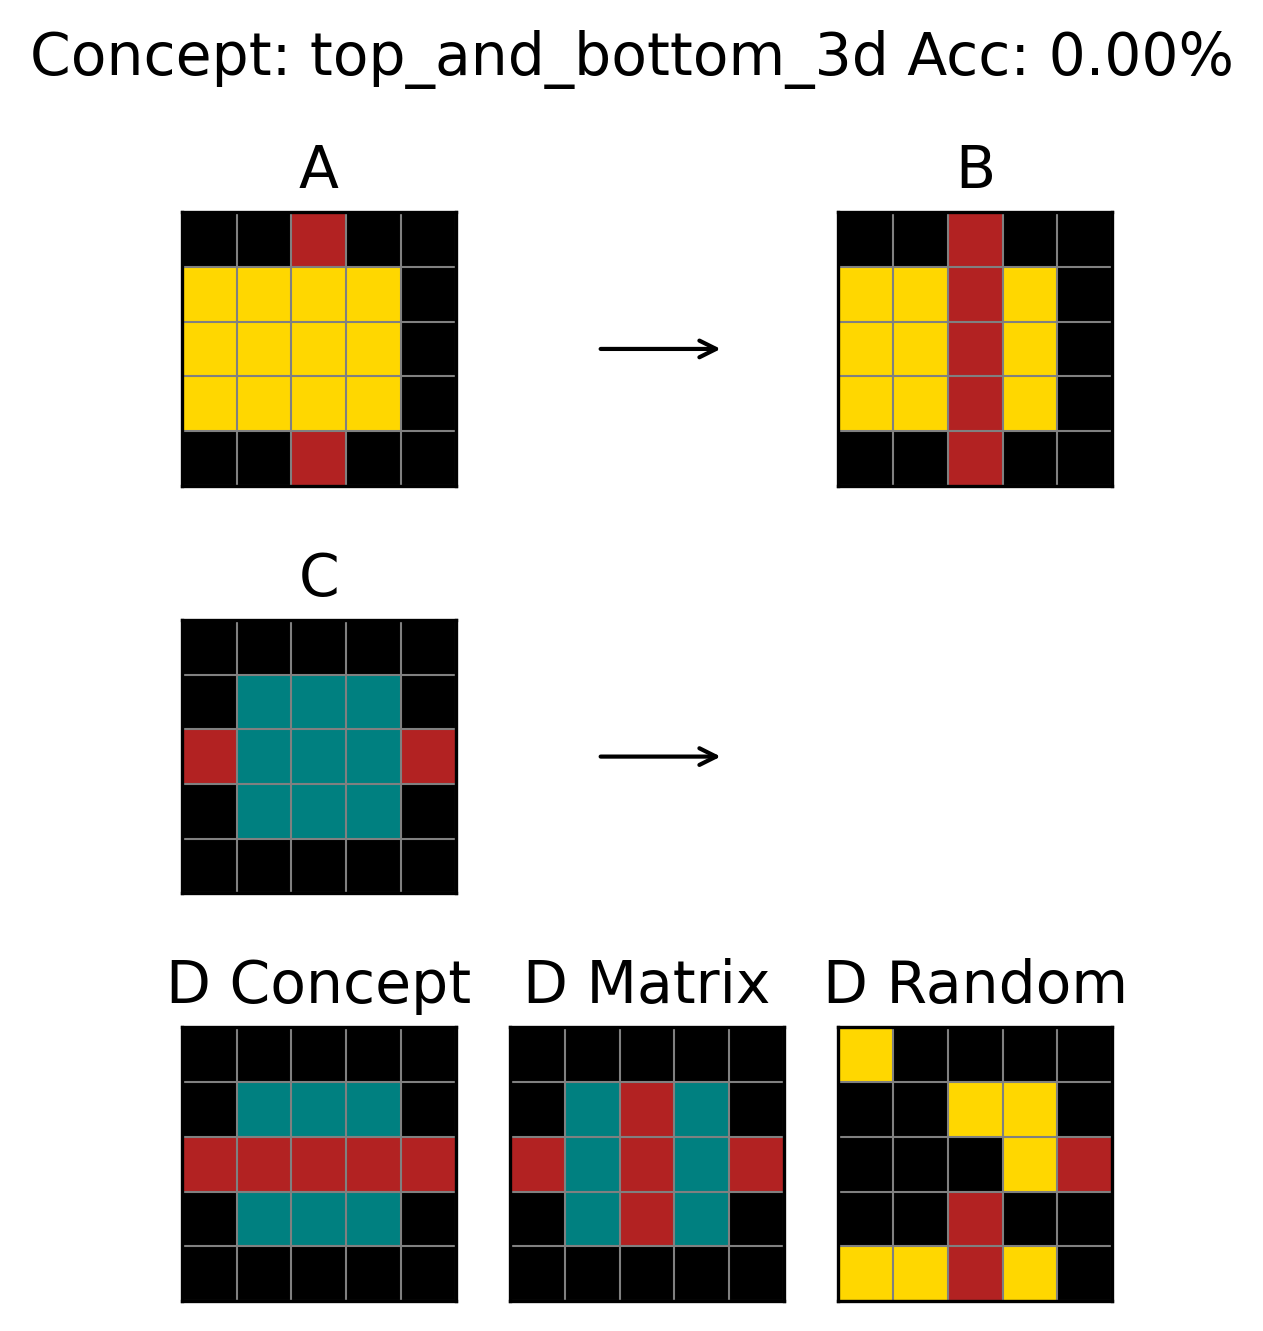

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


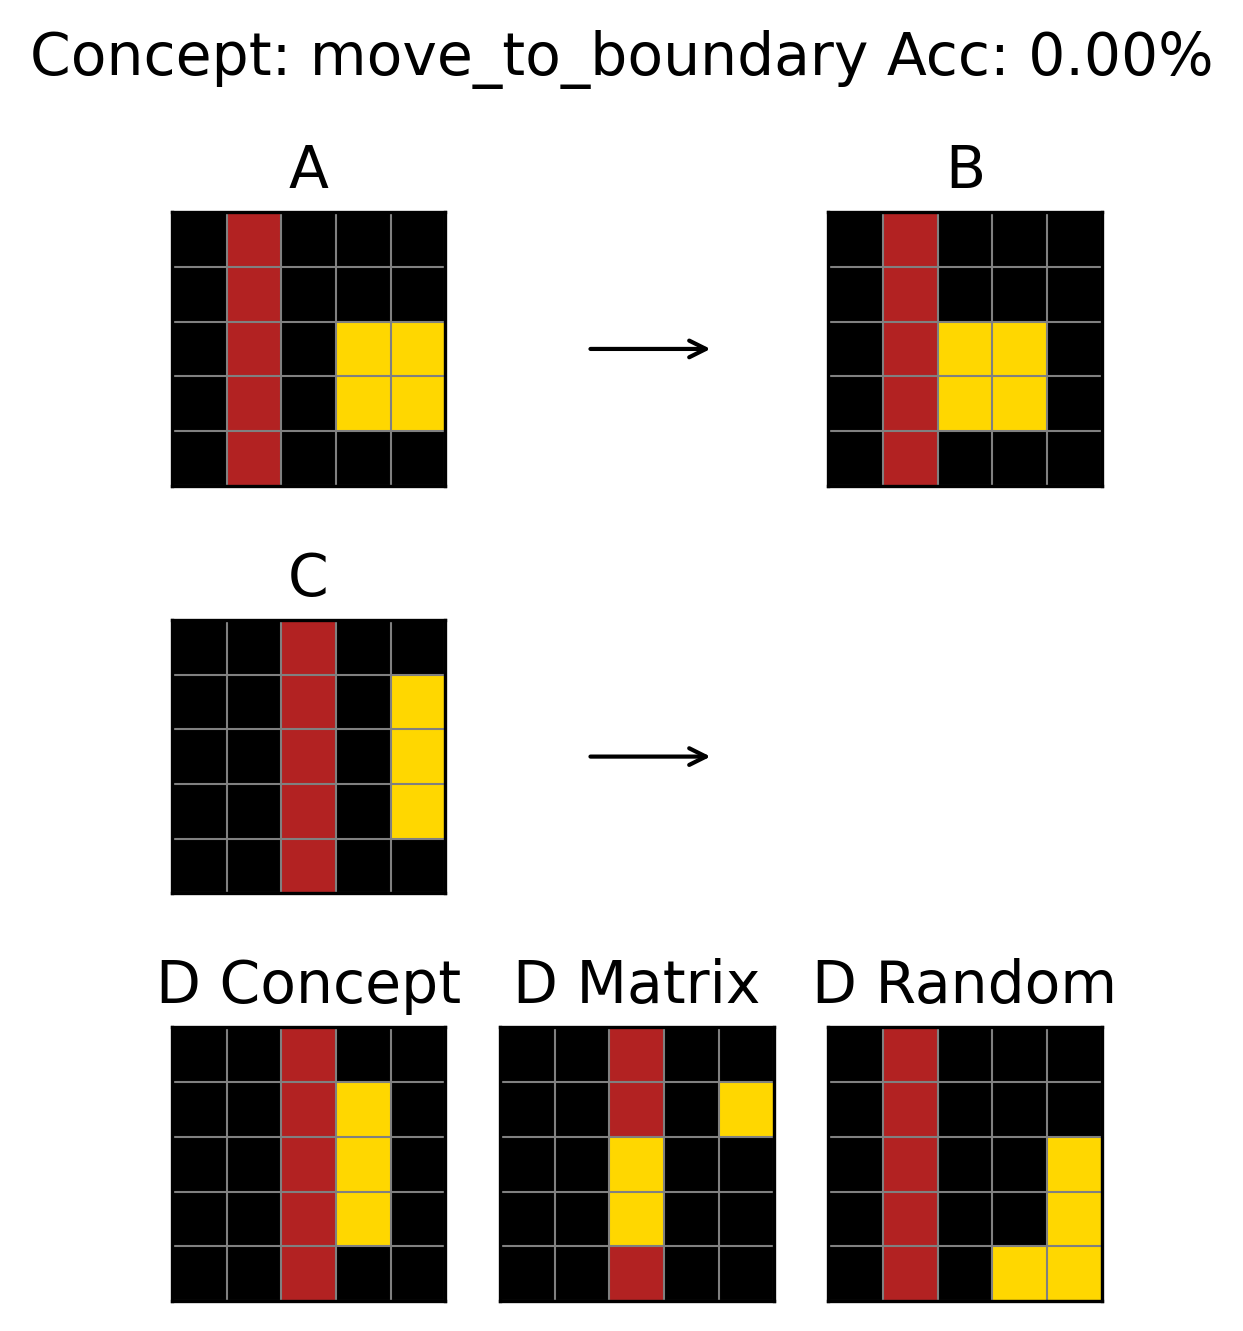

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


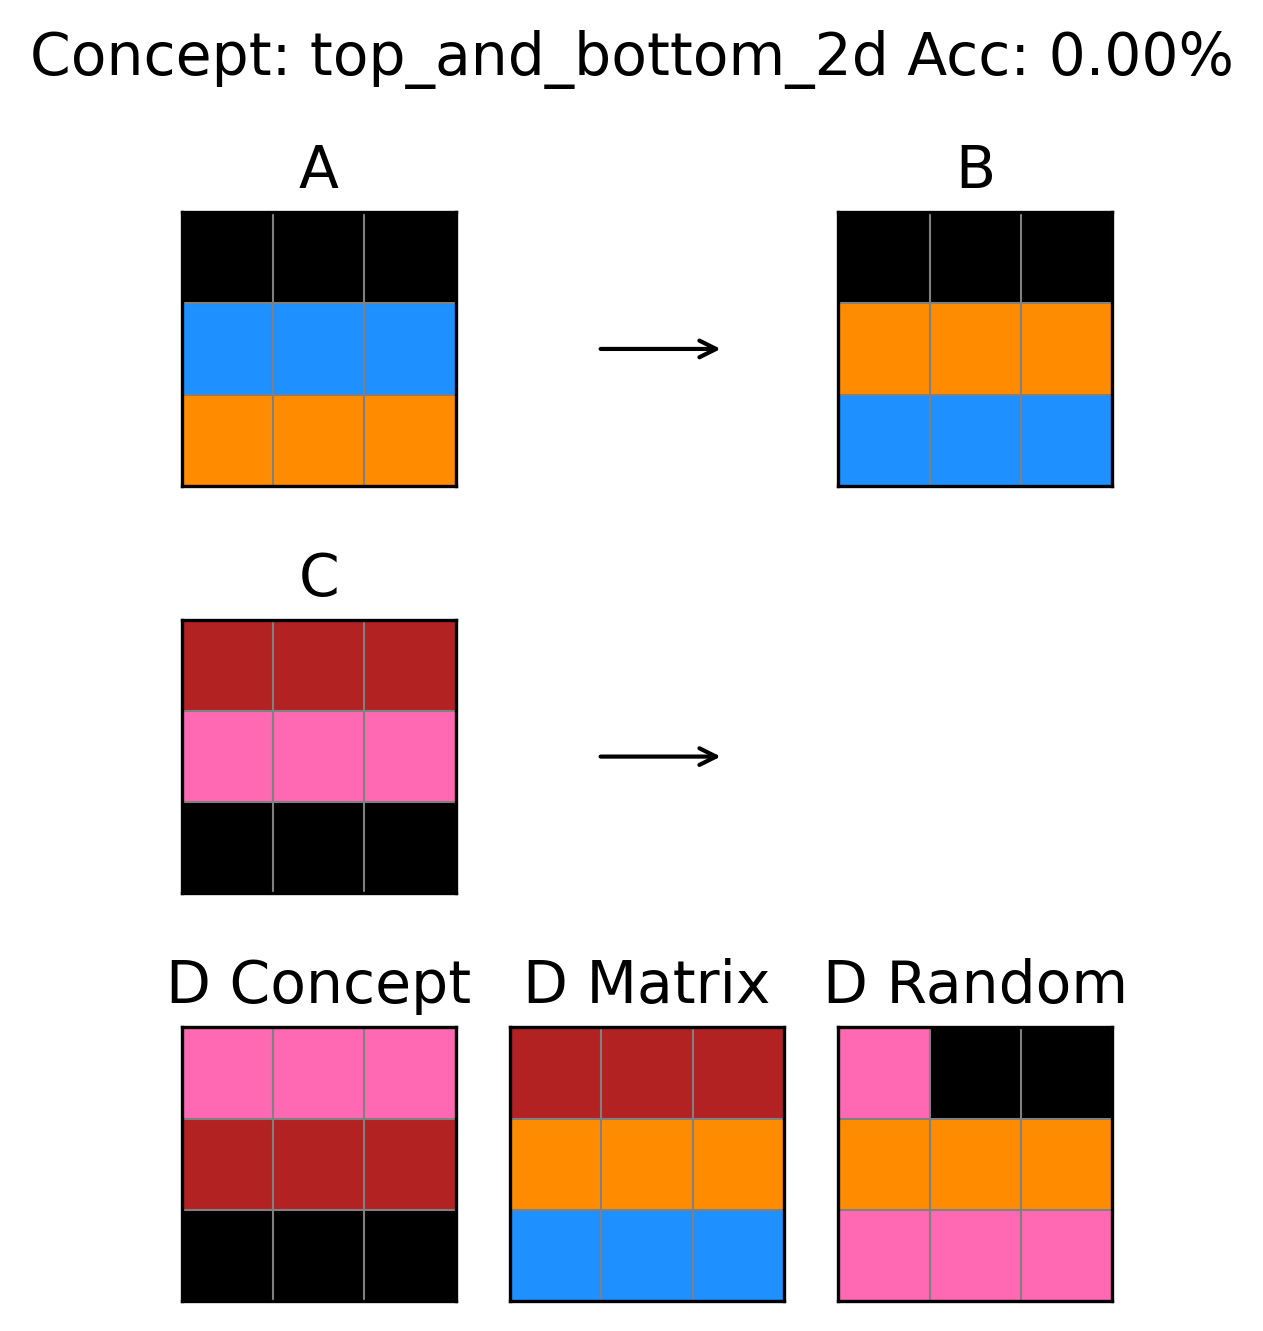

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_21412/478094604.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


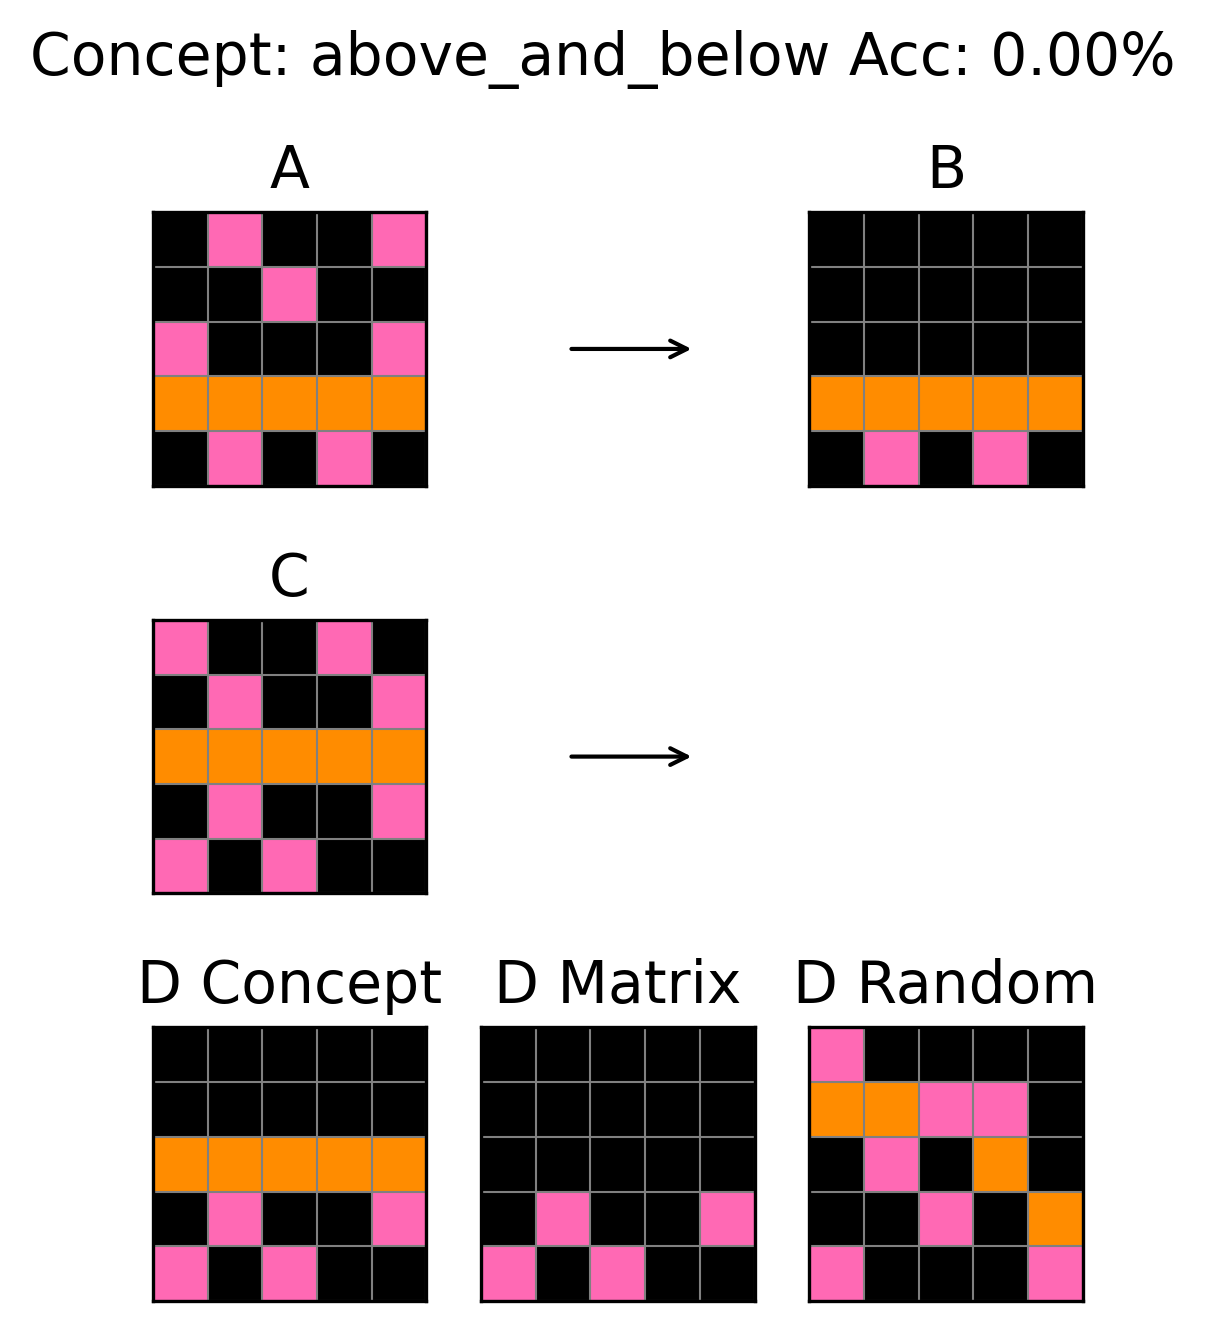

In [20]:
plot_most_common(filtered_df.groupby('item_id')['concept_acc'].mean(), top=5, ascending=True)

<Axes: ylabel='concept'>

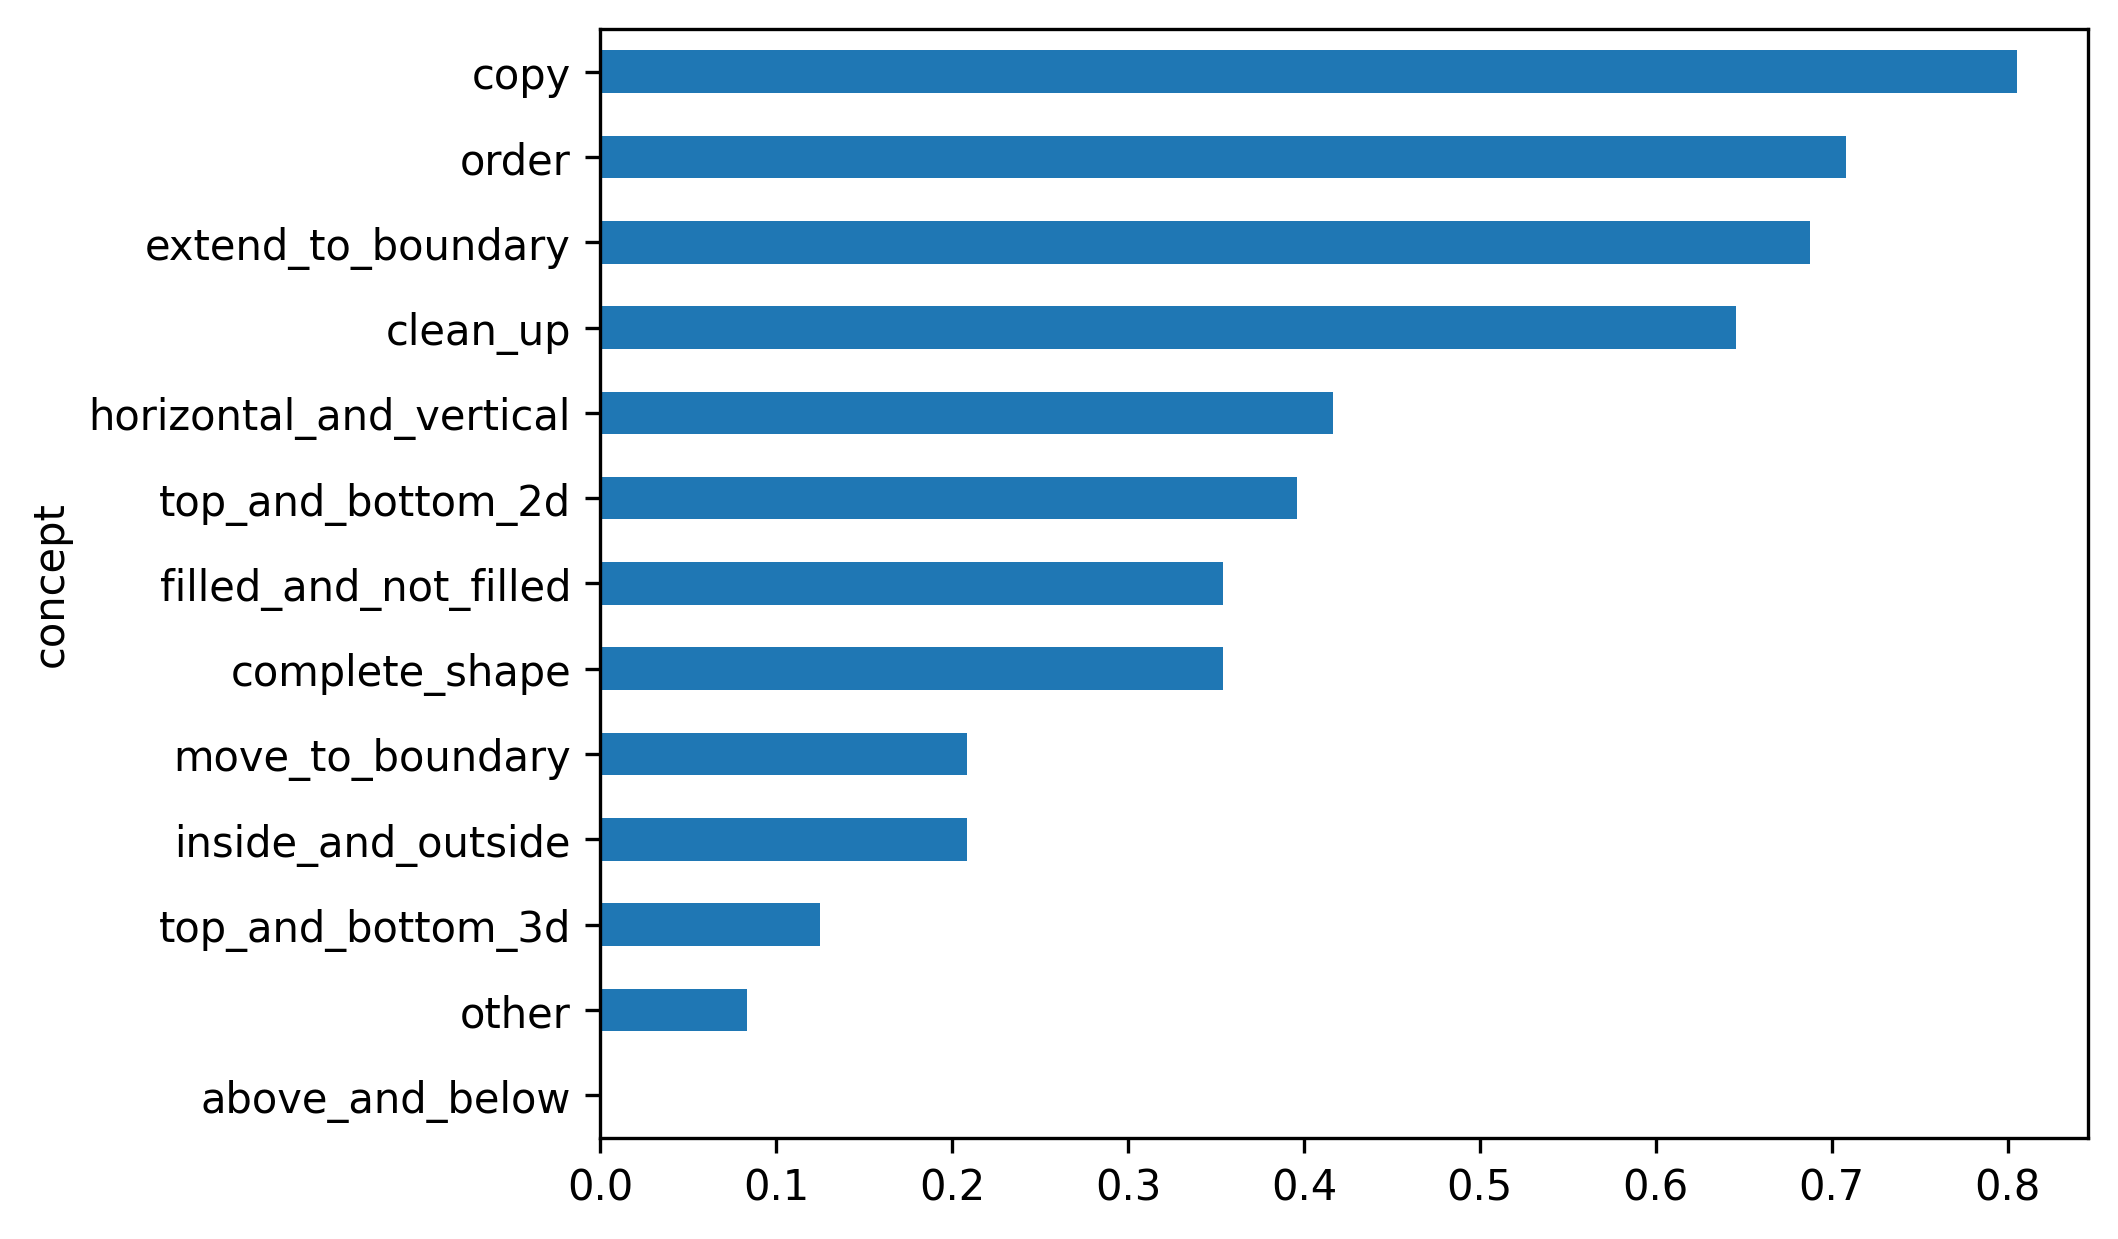

In [21]:
# horizontal
filtered_df.groupby('concept')['concept_acc'].mean().sort_values(ascending=True).plot(kind='barh')

# Open-ended

In [22]:
results_dir = 'data/results'
data_oe = json.load(open(f'{results_dir}/open_ended.json', 'r'))
dataset_oe = AmbigousARCDataset(items, 
    question_type='open_ended', 
    seed=42
)
oe = Eval(data_oe, dataset=dataset_oe, prop_test_thresh=None)
oe.print()

Number of models: 36
Concept: 0.15
Matrix: 0.02

Total excluded models: 4/40 (10%)
4/40 (10%) models excluded due to high no response rate.

In [24]:
abcd_filtered = Eval(data_abcd, dataset=dataset_abcd)
abcd_filtered.print()

Number of models: 13
Accuracy: 0.34

Total excluded models: 28/41 (68%)
12/41 (29%) models excluded due to high no response rate.
16/41 (39%) models excluded due to biased answer choices.

In [244]:
all_models = [mc_random.df['model'].unique(), abcd.df['model'].unique(), oe.df['model'].unique()]
models_filtered = set.intersection(*[set(models) for models in all_models])

mc_filtered = mc_random.df[mc_random.df['model'].isin(models_filtered)]
abcd_filtered = abcd.df[abcd.df['model'].isin(models_filtered)]
oe_filtered = oe.df[oe.df['model'].isin(models_filtered)]

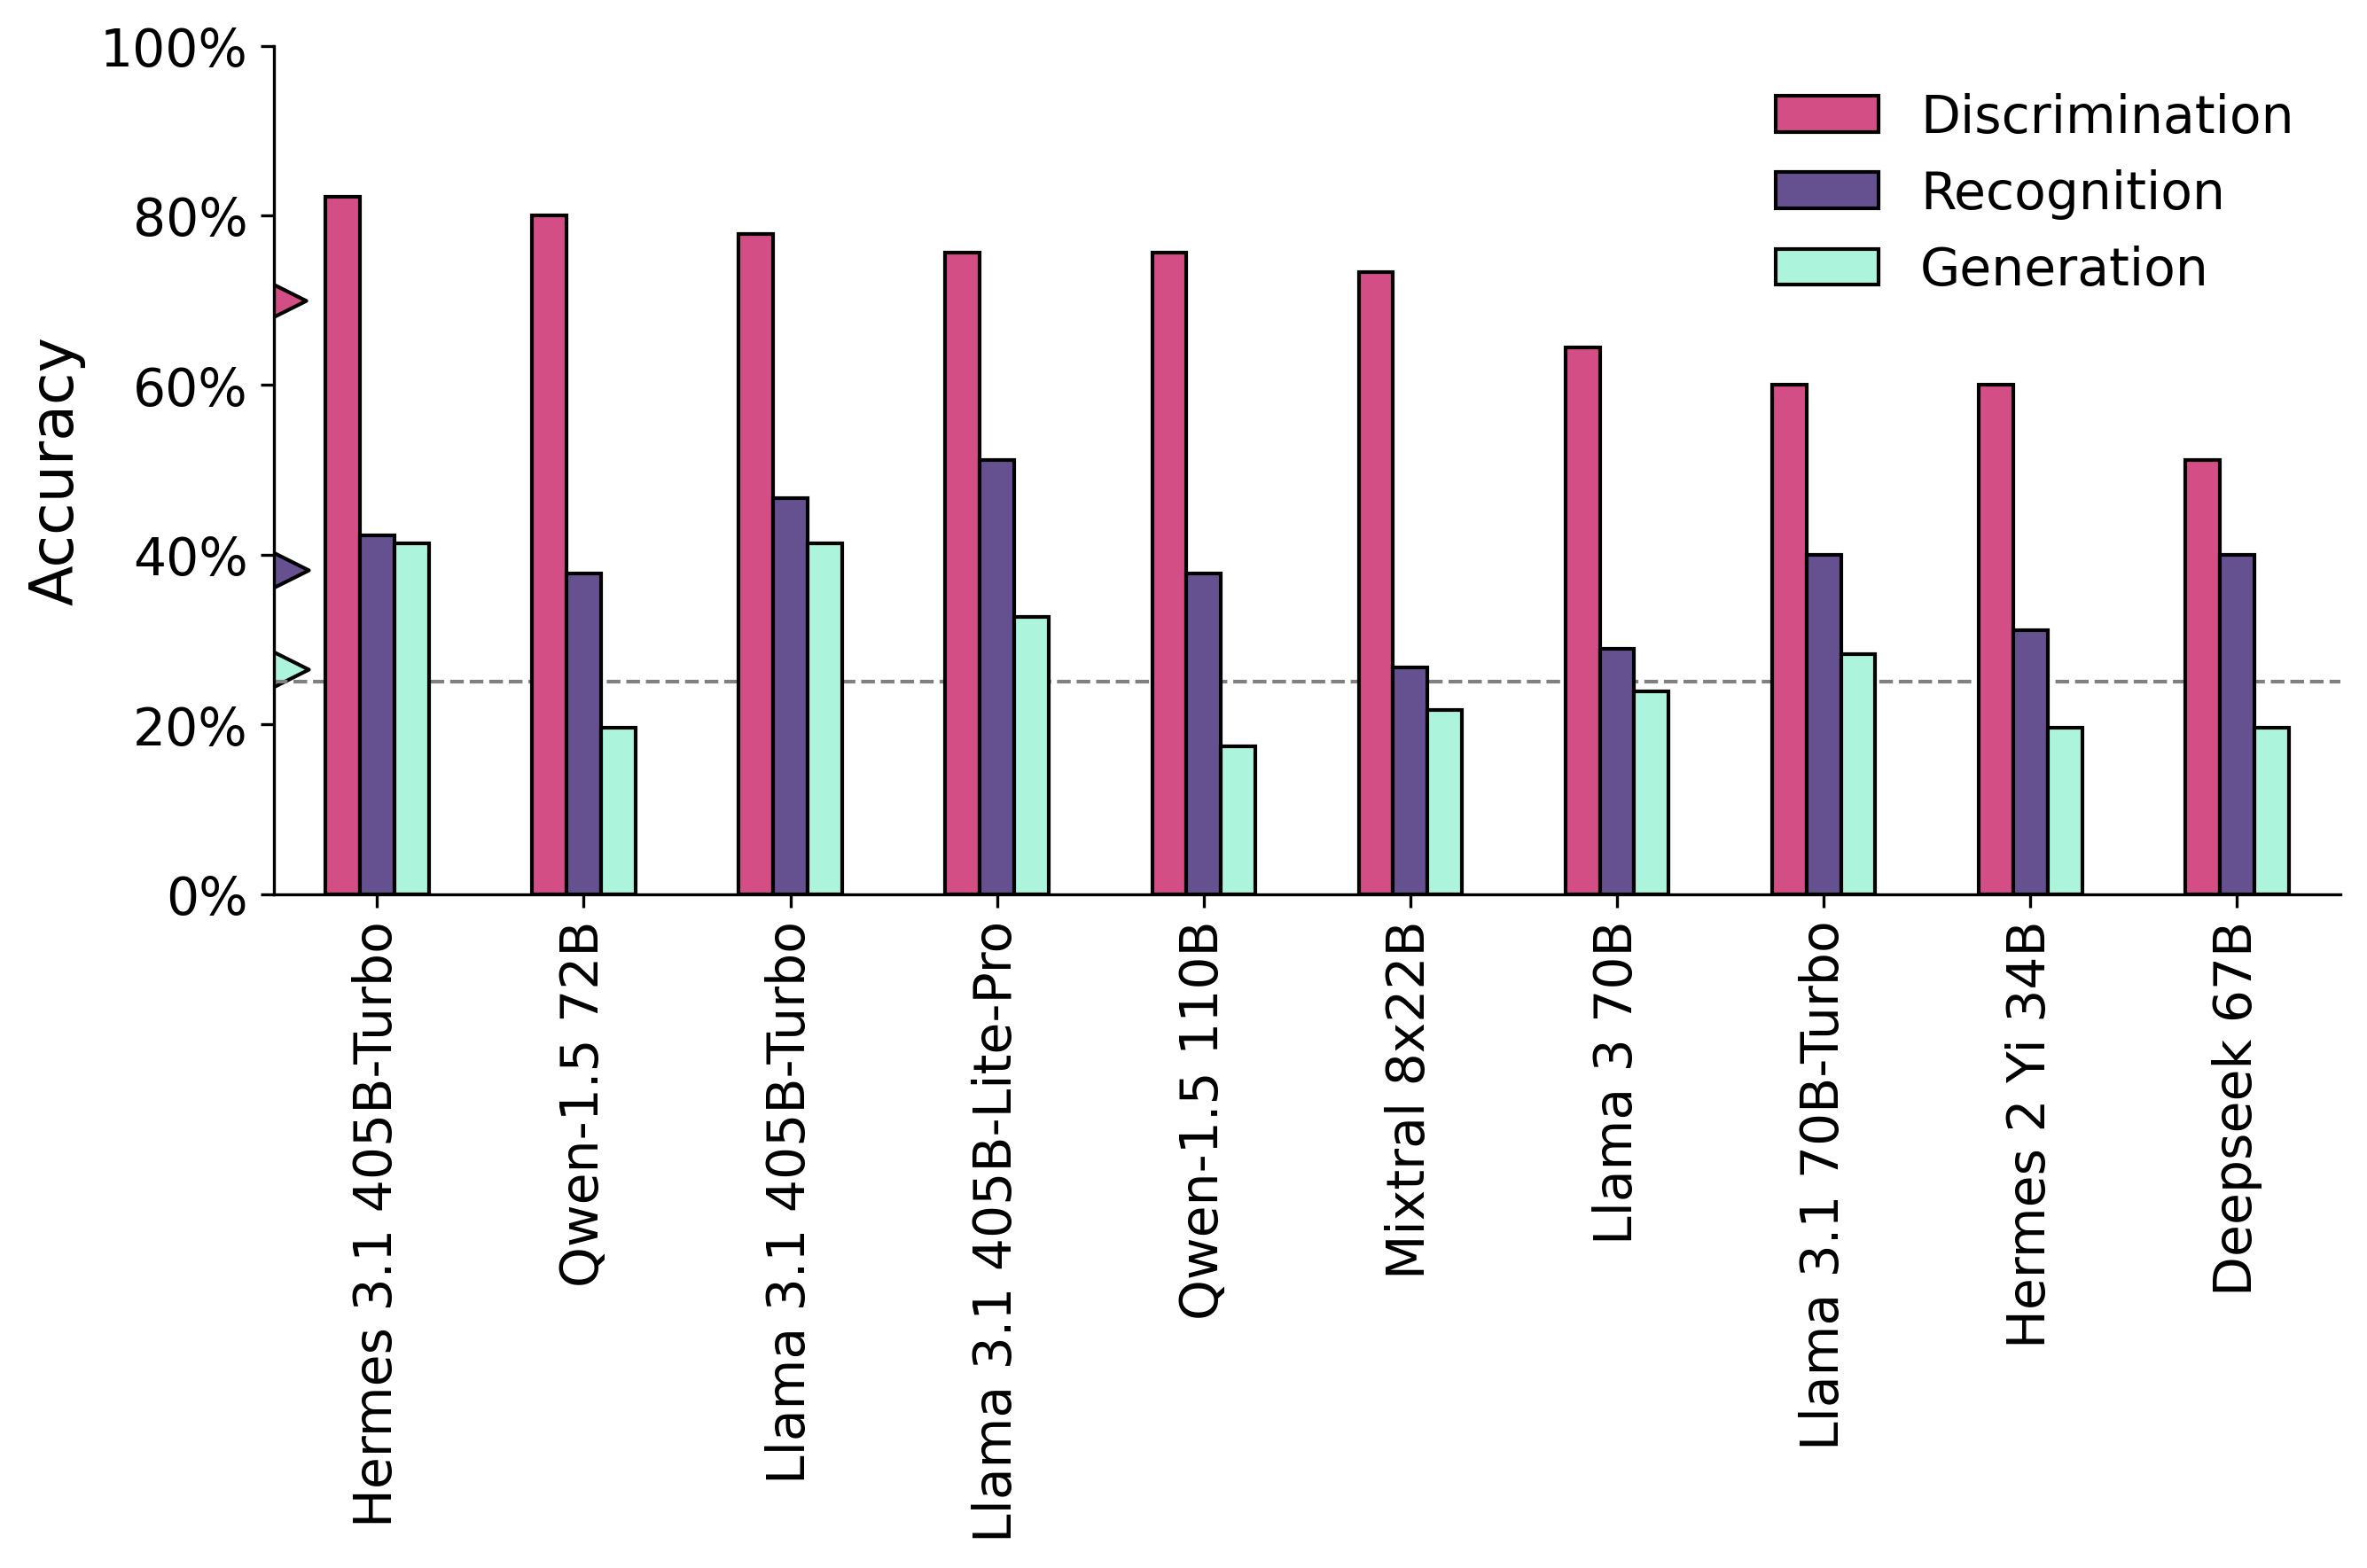

In [308]:
names = {
    'Hermes-3-Llama-3.1-405B-Turbo': 'Hermes 3.1 405B-Turbo',
    'Qwen1.5-72B-Chat': 'Qwen-1.5 72B',
    'Meta-Llama-3.1-405B-Instruct-Turbo': 'Llama 3.1 405B-Turbo',
    'Qwen1.5-110B-Chat': 'Qwen-1.5 110B',
    'Meta-Llama-3.1-405B-Instruct-Lite-Pro': 'Llama 3.1 405B-Lite-Pro',
    'Mixtral-8x22B-Instruct-v0.1': 'Mixtral 8x22B',
    'Llama-3-70b-chat-hf': 'Llama 3 70B',
    'Nous-Hermes-2-Yi-34B': 'Hermes 2 Yi 34B',
    'Meta-Llama-3.1-70B-Instruct-Turbo': 'Llama 3.1 70B-Turbo',
    'deepseek-llm-67b-chat': 'Deepseek 67B',
}

# DataFrame creation
df = pd.DataFrame({
    'Discrimination': mc_filtered.groupby('model')['concept_response'].mean(),
    'Recognition': abcd_filtered.groupby('model')['concept_acc'].mean(),
    'Generation': oe_filtered.groupby('model')['concept_response'].mean(),
})

# Sort the DataFrame
df = df.sort_values(by=['Discrimination', 'Recognition'], ascending=False)

# Model names adjustment
model_names = [model.split('/')[1] for model in df.index]
model_names = [names.get(name, name) for name in model_names]

# Plotting
ax = df.plot(kind='bar', figsize=(9, 6), color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black')

# Set axis labels and ticks
plt.ylabel('Accuracy', size=16)
plt.xticks(np.arange(0, len(df), 1), model_names, rotation=90, size=14)
plt.yticks(np.linspace(0, 1, num=6), [f'{x:.0%}' for x in np.linspace(0, 1, num=6)], size=14)
plt.xlabel('')
plt.ylim(0, 1)

# Calculate overall means
mean_discrimination = df['Discrimination'].mean()
mean_recognition = df['Recognition'].mean()
mean_generation = df['Generation'].mean()

# Overlay circles on the y-axis for the overall means
plt.scatter(-0.5, mean_discrimination, color='#d44e86', s=300, zorder=0, edgecolor='black', marker='>')
plt.scatter(-0.5, mean_recognition, color='#665190', s=350, zorder=0, edgecolor='black', marker='>')
plt.scatter(-0.5, mean_generation, color='#adf4dc', s=350, zorder=0, edgecolor='black', marker='>')

# Customize the legend
plt.legend(fontsize=14, edgecolor='none')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.axhline(y=1/4, color='grey', linestyle='--', linewidth=1, zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

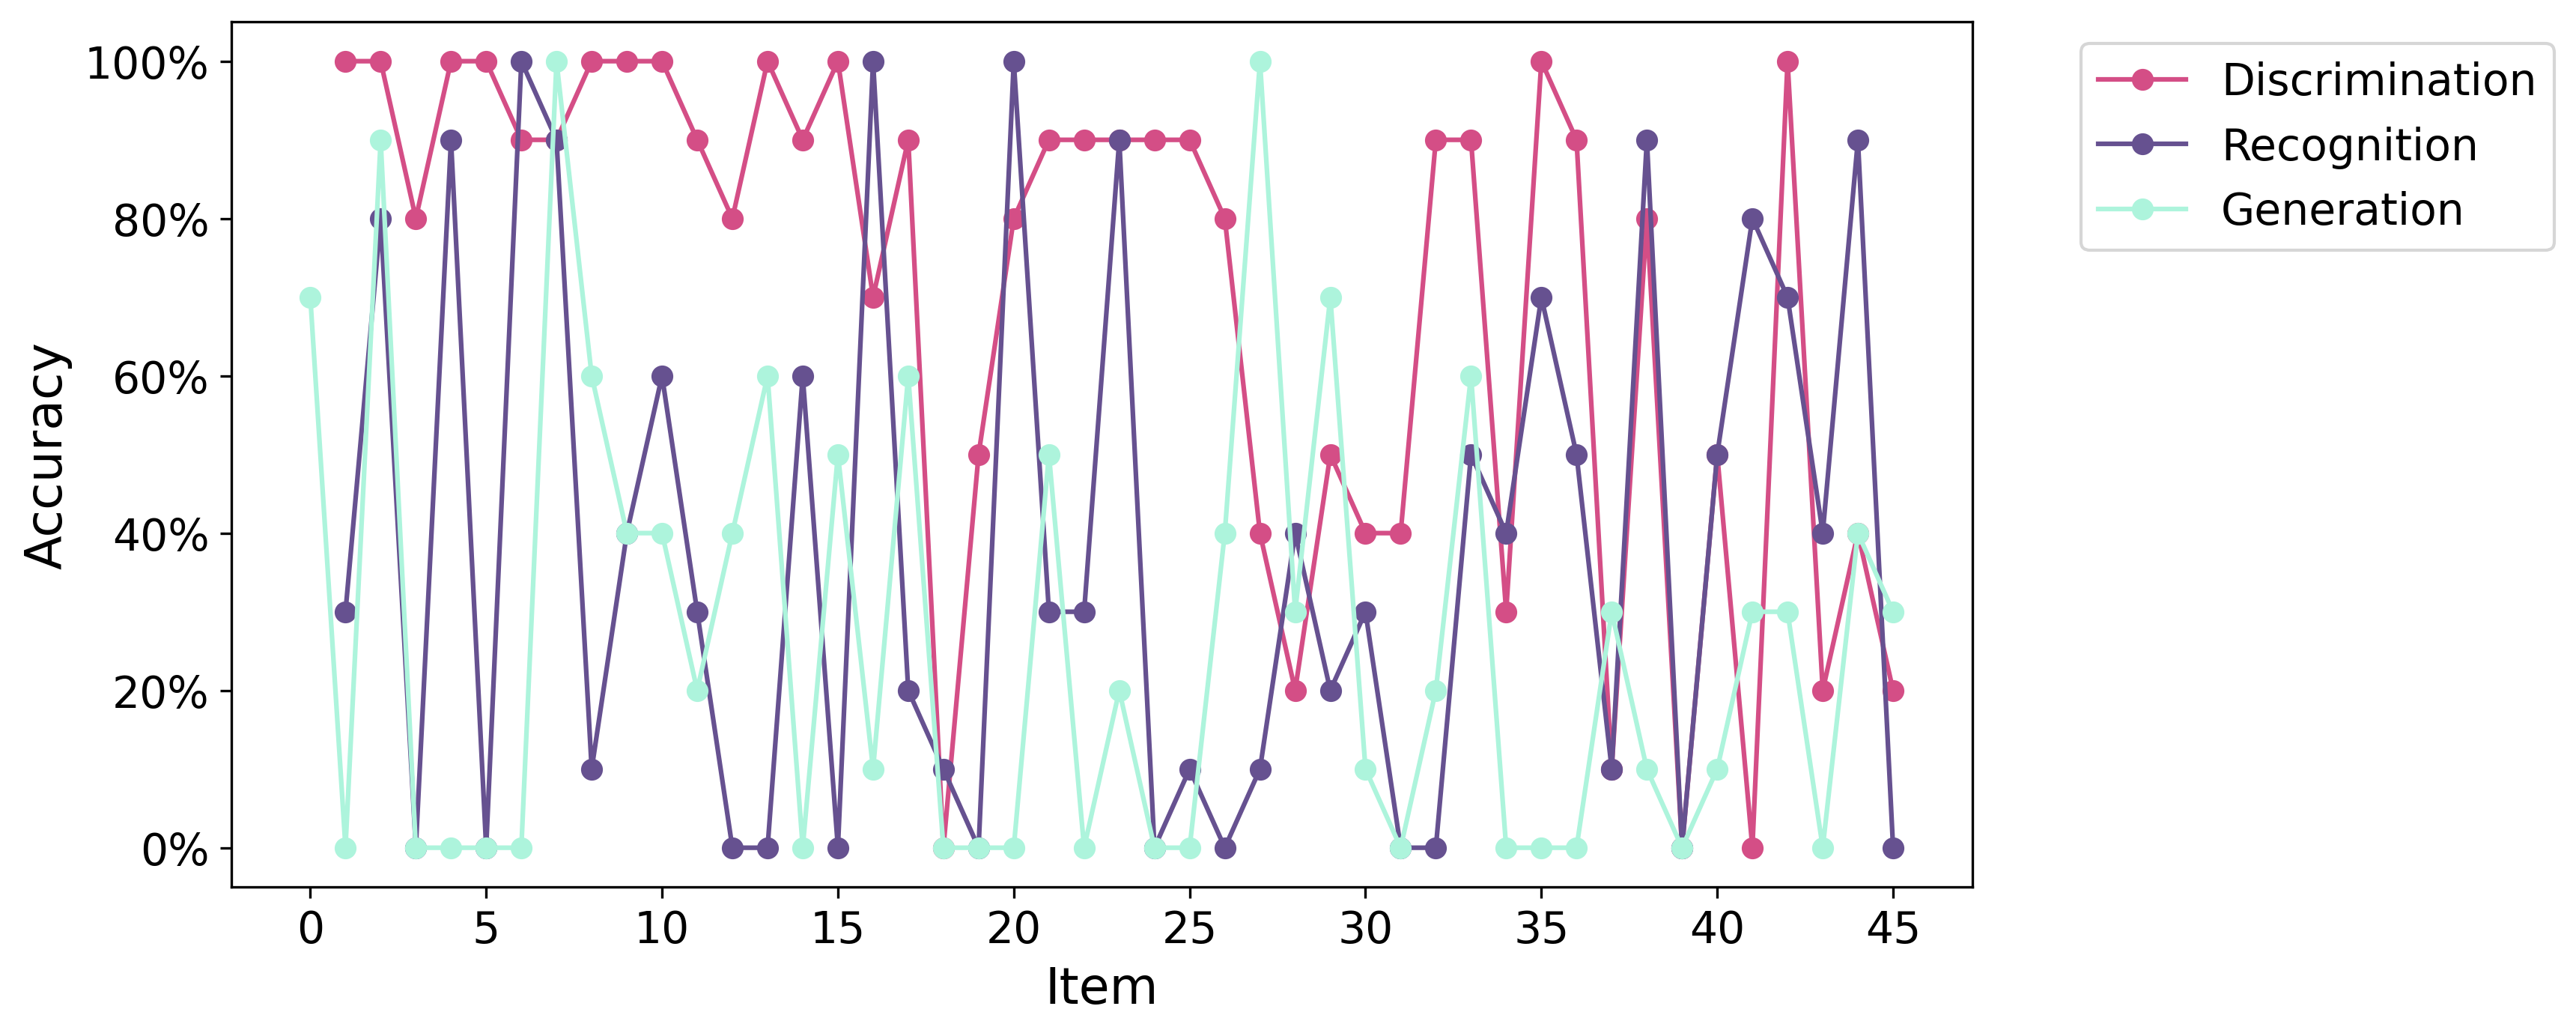

In [214]:
df_item_concept = pd.DataFrame({
    'Discrimination': mc_filtered.groupby('item_id')['concept_response'].mean(),
    'Recognition': abcd_filtered.groupby('item_id')['concept_acc'].mean(),
    'Generation': oe_filtered.groupby('item_id')['concept_response'].mean()
})
#df_item_concept = df_item_concept.sort_values(by='Multiple Choice', ascending=False)
# line plot
df_item_concept.plot(figsize=(10, 5), color=['#d44e86', '#665190', '#adf4dc'], marker='o')
plt.ylabel('Accuracy', size=16)
plt.xlabel('Item', size=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.yticks(np.linspace(0, 1, num=6), [f'{x:.0%}' for x in np.linspace(0, 1, num=6)], size=14)
plt.xticks(np.arange(0, len(df_item_concept), 5), np.arange(0, len(df_item_concept), 5))
plt.show()


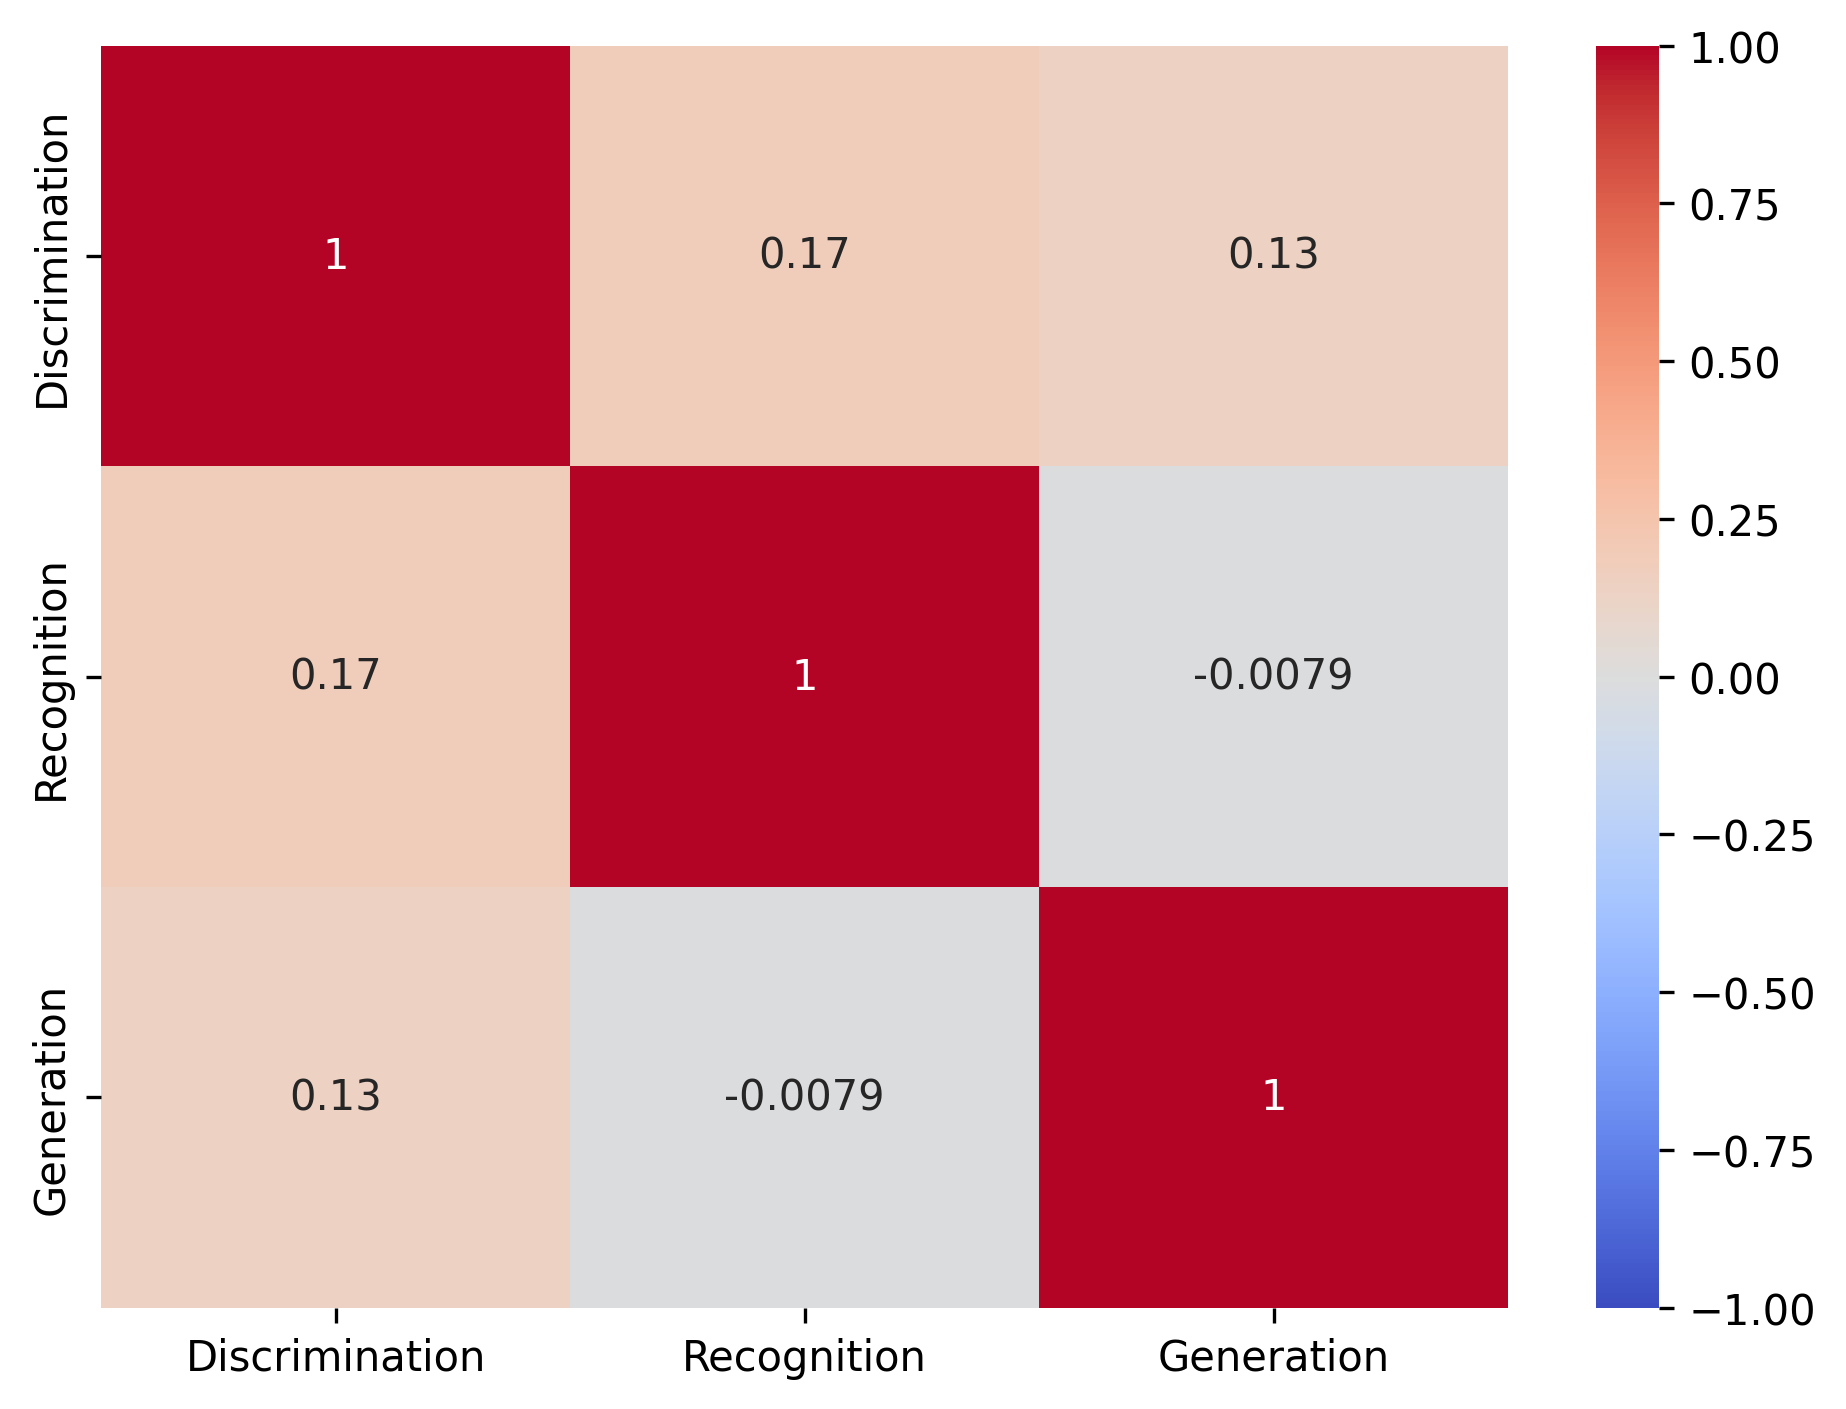

In [241]:
import seaborn as sns
sns.heatmap(df_item_concept[1:].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.tight_layout()
plt.show()

In [180]:
oe_filtered.groupby('matrix_response')['logprobs'].mean()

matrix_response
False   -0.024139
True    -0.012274
Name: logprobs, dtype: float64

In [268]:
mc_lp = mc_filtered.groupby('choice')['logprobs'].mean()
mc_lp_err = mc_filtered.groupby('choice')['logprobs'].sem()

abcd_lp = abcd_filtered.groupby('concept_acc')['logprobs'].mean()
abcd_lp_err = abcd_filtered.groupby('concept_acc')['logprobs'].sem()

oe_concept_lp = oe_filtered.groupby('concept_response')['logprobs'].mean().loc[True]
oe_concept_lp_err = oe_filtered.groupby('concept_response')['logprobs'].sem().loc[True]
or_matrix_lp = oe_filtered.groupby('matrix_response')['logprobs'].mean().loc[True]
or_matrix_lp_err = oe_filtered.groupby('matrix_response')['logprobs'].sem().loc[True]

oe_filtered.loc[:, 'other_response'] = oe_filtered['matrix_response'] + oe_filtered['concept_response']
oe_other_lp = oe_filtered.groupby('other_response')['logprobs'].mean().loc[False]
oe_other_lp_err = oe_filtered.groupby('other_response')['logprobs'].sem().loc[False]

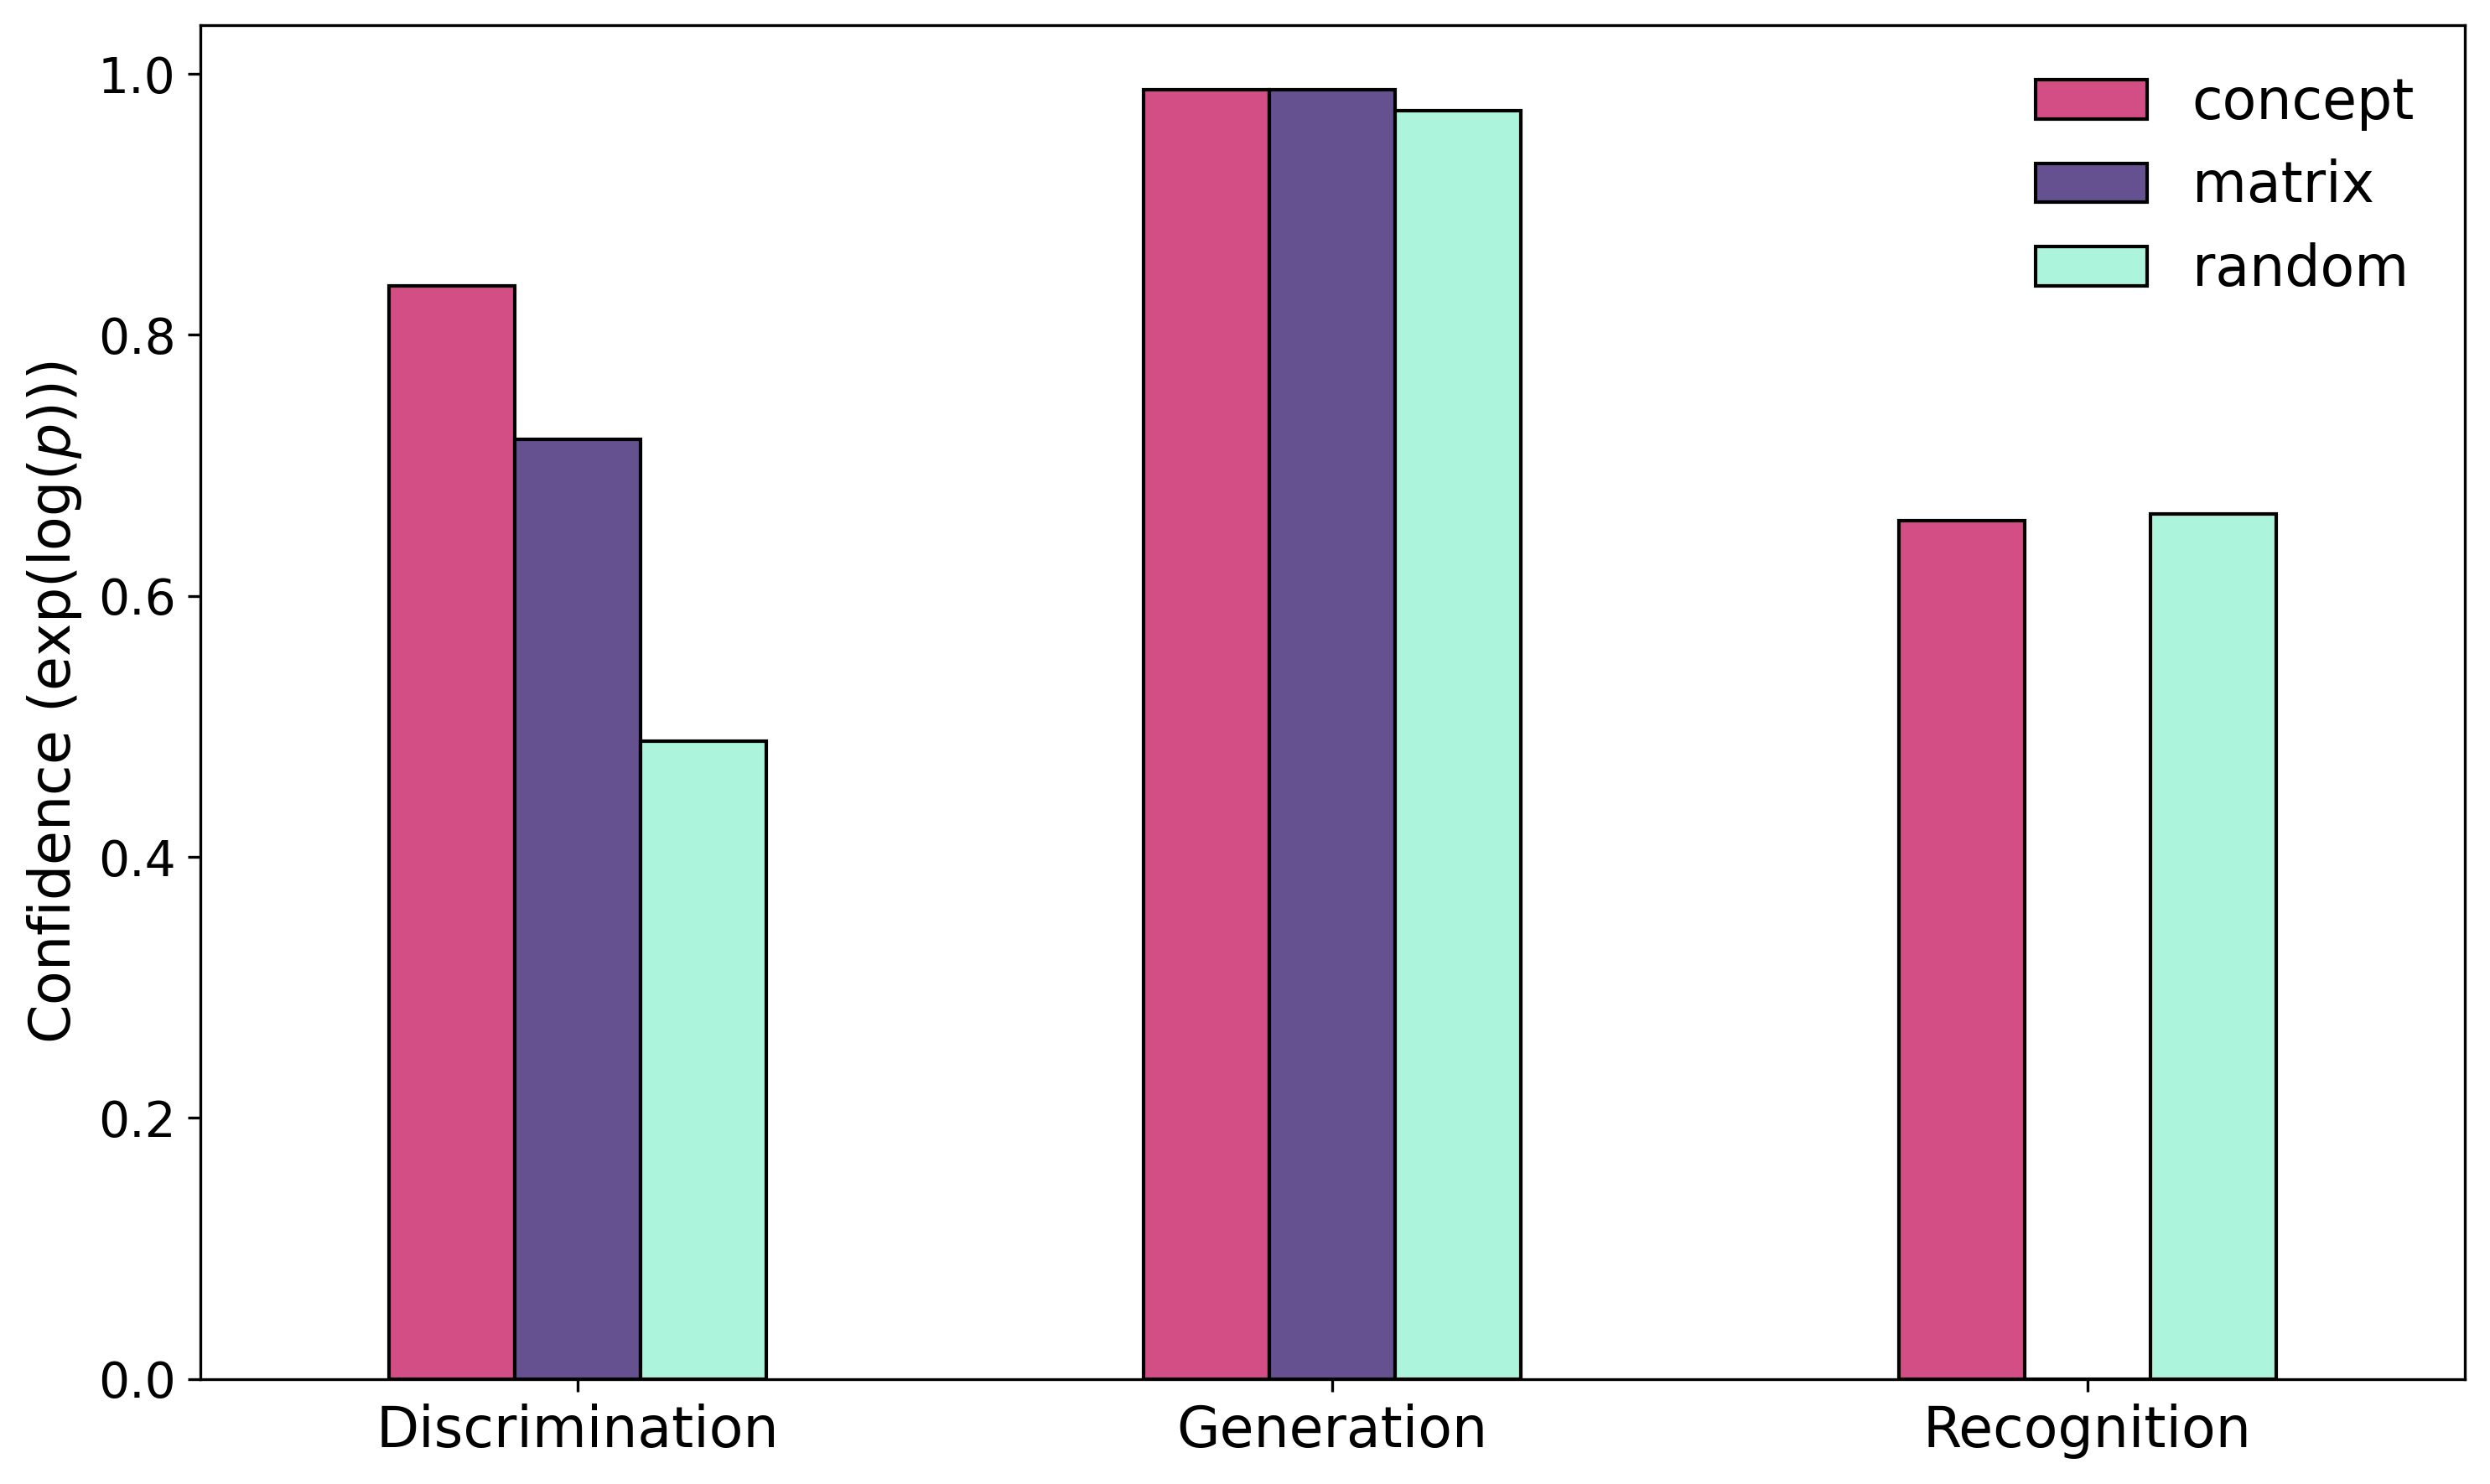

In [307]:
df_lp = pd.DataFrame({
    'Discrimination': mc_lp.to_dict(),
    'Generation': {'concept': oe_concept_lp,
                    'matrix': or_matrix_lp, 
                    'random': oe_other_lp},
    'Recognition': {'concept': abcd_lp.loc[True],
                    'matrix': np.nan,
                    'random': abcd_lp.loc[False]},
}).T
df_lp = np.exp(df_lp)
plt.rcParams['text.usetex'] = False
df_lp.plot(kind='bar', figsize=(10, 6), color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black')
plt.ylabel('Confidence ($\\exp(\\log(p))$)', size=16)
plt.xticks(size=16, rotation=0)
plt.yticks(size=14)
plt.legend(fontsize=16, edgecolor='none')
plt.tight_layout()
plt.show()

In [283]:
np.exp(df_lp)

,concept,matrix,random
Discrimination,0.837534,0.720297,0.488690
Generation,0.987949,0.987801,0.971784
Recognition,0.657517,NaN,0.662572


In [272]:
abcd_lp.to_dict()

{False: -0.41162586590198147, True: -0.4192850594139063}

In [271]:
df_lp

,Discrimination,Recognition,Generation
concept,-0.177294,NaN,-0.012124
matrix,-0.328092,NaN,-0.012274
random,-0.716028,NaN,-0.028622
False,NaN,-0.411626,NaN
True,NaN,-0.419285,NaN


In [269]:
oe_concept_lp

-0.01212438503498802

In [247]:
mc_lp

choice
concept   -0.177294
matrix    -0.328092
random    -0.716028
Name: logprobs, dtype: float64

In [245]:
abcd_lp

concept_acc
False   -0.411626
True    -0.419285
Name: logprobs, dtype: object

In [246]:
oe_lp

concept_response
False   -0.028090
True    -0.012124
Name: logprobs, dtype: float64

In [ ]:
oe_filtered.groupby('concept_response')['logprobs'].mean()